In [3]:
import pandas as pd
import numpy as np
import gspread
from google.colab import auth

from google.auth import default
from gspread_dataframe import get_as_dataframe
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
!pip install wordfreq
from wordfreq import zipf_frequency
from sklearn.model_selection import StratifiedKFold, cross_validate
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns


In [4]:

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



# **Adult Participants**

In [5]:
# read files and make them dataframes
words = gc.open_by_url('https://docs.google.com/spreadsheets/d/1mDg1HuTNgquVK4a9T5Nu--21W0NJzsSPASMfl6A1gCo/edit?gid=0#gid=0')
pre = gc.open_by_url('https://docs.google.com/spreadsheets/d/1EvC0PwMzbipWXdxIbCXc6urVQZjDJV4oRNRG68WaWnQ/edit?resourcekey=&gid=974437907#gid=974437907')
post = gc.open_by_url('https://docs.google.com/spreadsheets/d/1rl_UsiBDM7flcRjVeB4HtysQkVA1M3fwJmDx7Ct1Cp0/edit?resourcekey=&gid=1754048364#gid=1754048364')

wordsheet = words.worksheet('Sheet1')
presheet = pre.worksheet('Sheet1')
postsheet = post.worksheet('Sheet1')

word = get_as_dataframe(wordsheet)
pre = get_as_dataframe(presheet)
post = get_as_dataframe(postsheet)

url = "/content/drive/MyDrive/Colab Notebooks/challenging_words_zipf.xlsx"
word_dataset = pd.read_excel(url)

medical_dys = gc.open_by_url('https://docs.google.com/spreadsheets/d/13W3FAc_f1tfZU3SXAKlBl3cyKoqPIWtHNJh3J1jm3t8/edit?gid=1533757235#gid=1533757235')
self_dys = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Emyuq_kbaRgTJEDVRqF8dT2HA-L4ZsIs8SSzzuX0U7o/edit?gid=1428308089#gid=1428308089')

medsheet = medical_dys.worksheet('Sheet1')
selfsheet = self_dys.worksheet('Sheet1')

medical_dyslexic = get_as_dataframe(medsheet)
self_dyslexic = get_as_dataframe(selfsheet)
word.columns

Index(['Prolific ID', 'words', 'difficulty', 'letters', 'reason',
       'reason explanation', 'letter explanation', 'timeStamps', 'url',
       'date and time', 'Server Timestamp', 'familiarity', 'length',
       'some letters'],
      dtype='object')

In [6]:
word_dataset.columns

Index(['word', 'long_words', 'diagraphs', 'not_freq_words', 'silent_letters',
       'vowel_digraphs', 'has_homophones', 'difficult_orthography', 'zipf'],
      dtype='object')

In [7]:
# add a dyslexia score based on the screener to the word dataset

pre = pre.rename(columns={'Please enter your Prolific ID:':'Prolific ID'})
pre = pre.drop_duplicates(subset='Prolific ID')
duplicate_ids = pre['Prolific ID'][pre['Prolific ID'].duplicated()]

pre['dys-score'] = ((pre.iloc[:,13:18]=='Yes').sum(axis=1))*3 + ((pre.iloc[:,18:24]=='Yes').sum(axis=1))*2 + ((pre.iloc[:,24:25]=='Yes').sum(axis=1))*3
word = word.merge(pre[['Prolific ID','dys-score']], on='Prolific ID', how='left' )

word['dys-score'] = word['dys-score'].fillna(-1)
word['dys-score'] = word['dys-score'].astype(int)

word = word.drop_duplicates(keep='first')

# add a column if they self-diagnosed themselves as dyslexic
word = word.merge(pre[['Have you ever been diagnosed with Dyslexia?','Prolific ID']], on='Prolific ID', how='left' )
word = word.rename(columns={'Have you ever been diagnosed with Dyslexia?':'self-diagnosed'})

# rename columns and merge it with the challanging word dataset
word_dataset = word_dataset.rename(columns={'word':'words'})
word = word.merge(word_dataset, on='words', how='left')

# extract the last difficulty of each word
word['last_difficulty'] = word['difficulty'].fillna('').astype(str).str.split(',').str[-1]

print(word.columns)

# extract ids from prolific demography datasets -> Project: dyslexia - Medical
medical = medical_dyslexic['Participant id'].to_list()
word['med_dys'] = word['Prolific ID'].isin(medical)


# extract ids from prolific demography datasets -> Project: Dyslexia
self_dyslex = self_dyslexic['Participant id'].to_list()
word['self_dys_prolific'] = word['Prolific ID'].isin(self_dyslex)

# remove unnecessary columns
word = word.drop(columns=['difficulty', 'timeStamps', 'reason', 'url', 'Server Timestamp'])

word = word[word['last_difficulty'].astype(str).str.strip() != '']
word['Prolific ID'][word['Prolific ID']=='66d9a9dfafa9f033be6ee60a\n']='66d9a9dfafa9f033be6ee60a'
pre['What is your gender?'][pre['What is your gender?'].isna()]='unknown'
pre['What is your age? (in years)'][pre['What is your gender?']=='unknown'] = 0


def safe_zipf(word):
    if isinstance(word, str):
        return zipf_frequency(word, 'en')
    else:
        return None
word['zipf'] = word['words'].apply(safe_zipf)


Index(['Prolific ID', 'words', 'difficulty', 'letters', 'reason',
       'reason explanation', 'letter explanation', 'timeStamps', 'url',
       'date and time', 'Server Timestamp', 'familiarity', 'length',
       'some letters', 'dys-score', 'self-diagnosed', 'long_words',
       'diagraphs', 'not_freq_words', 'silent_letters', 'vowel_digraphs',
       'has_homophones', 'difficult_orthography', 'zipf', 'last_difficulty'],
      dtype='object')


In [8]:
pre['What is your gender?'] = pre['What is your gender?'].str.strip().str.lower()

gender_map = {
    'male': 'Male',
    'female': 'Female',
    'man': 'Male',
    'woman': 'Female',
    'nonbinary': 'Non-binary',
    'non-binary': 'Non-binary',
    'transgender': 'Transgender',
    'm':'Male',
    'femal':'Female',
    'nonbinary transmasculine' : 'Non-binary',
    'f':'Female',
    'non binary' : 'Non-binary',
    'transmasculine' : 'Transgender'
}

pre['What is your gender?'] = pre['What is your gender?'].map(gender_map).fillna(pre['What is your gender?'])

pre['What is your gender?'].value_counts()


,count
What is your gender?,
Female,145
Male,117
unknown,11
Non-binary,8
transwoman,2
agender,2
Transgender,1


In [9]:
# data integration (pre-survey and word dataset)
print(pre['Prolific ID'].nunique(), word['Prolific ID'].nunique())

pre_list = pre['Prolific ID'].to_list()
word_list = word['Prolific ID'].to_list()

temp = word[~word['Prolific ID'].isin(pre_list)]
print(temp['Prolific ID'].nunique()) # must be 0

pre = pre[pre['Prolific ID'].isin(word_list)]
print(pre['Prolific ID'].nunique())


# Remove under affected participants

l = ['67ed8f12809e993b465ce944', '67ccc62a623f466a4ad19371']
word = word[~word['Prolific ID'].isin(l)]
print(word['Prolific ID'].nunique())

286 222
5
217
220


In [10]:
# Convert to datetime
word['date and time'] = pd.to_datetime(word['date and time'])

# Keep only participants with ≤ 55 ratings
counts = word.groupby('Prolific ID').size()
valid_ids = counts[counts <= 55].index
filtered = word[word['Prolific ID'].isin(valid_ids)]

# Identify participants who ONLY used "1" or "2"
only_1_2_ids = filtered.groupby('Prolific ID')['last_difficulty'].apply(
    lambda x: x.astype(str).str.strip().isin(['1','2']).all()
)
only_1_2_ids = only_1_2_ids[only_1_2_ids].index
print('len', len(only_1_2_ids))


# Compute durations for those participants
durations = filtered.groupby('Prolific ID')['date and time'].max() - filtered.groupby('Prolific ID')['date and time'].min()
durations_seconds = durations.dt.total_seconds()

careless_durations = durations_seconds.loc[only_1_2_ids]

# Compute cutoff = 25th percentile
quartiles = careless_durations.quantile([0.25, 0.5, 0.75])
cutoff = careless_durations.quantile(0.25)

print("Quartiles of their session durations (seconds):")
print(quartiles)
print("\nCutoff (25th percentile of careless durations):", cutoff, "seconds ≈", cutoff/60, "minutes")
# print(careless_durations.sort_values())

len 37
Quartiles of their session durations (seconds):
0.25    169.0
0.50    262.5
0.75    536.5
Name: date and time, dtype: float64

Cutoff (25th percentile of careless durations): 169.0 seconds ≈ 2.816666666666667 minutes


In [11]:
# Detect and remove the unreliable participants just selected 1
df = word.groupby('Prolific ID')['last_difficulty']
all_ones = df.apply(lambda s: (s == '1').all())
all_ones.value_counts()
num_participants_all_1 = int(all_ones.sum())
ids_all_1 = all_ones[all_ones].index.tolist()

print('only 1', num_participants_all_1)  # count and a peek at first 10 IDs

# word_all1 = word[word['Prolific ID'].isin(ids_all_1)].copy()

# Drop all rows from those participants
word = word[~word['Prolific ID'].isin(ids_all_1)].copy()

# Detect and remove the unreliable participants just selected 1 and 2 and did not take enough time
df1 = word.copy()
df1['last_difficulty'] = pd.to_numeric(df1['last_difficulty'], errors='coerce')
df1['date and time'] = pd.to_datetime(df1['date and time'], errors='coerce')
df1 = df1.dropna(subset=['last_difficulty', 'date and time'])

df = df1.groupby('Prolific ID')

only_12 = df['last_difficulty'].apply(lambda s: s.isin([1,2]).all())
dur_min = (df['date and time'].max() - df['date and time'].min()).dt.total_seconds() / 60
ids_3 = dur_min.index[only_12 & (dur_min < cutoff)].tolist()
print('ids_1,2',len(ids_3))


# Drop all rows from those participants
word = word[~word['Prolific ID'].isin(ids_3)].copy()
print(word['Prolific ID'].nunique())
mask = (
    (word['med_dys'] == True)|(word['dys-score'] >=12 ) )

word_dys = word[mask]
print('word_dys',word_dys['Prolific ID'].nunique())
word_notdys = word[~mask]
print('word_notdys',word_notdys['Prolific ID'].nunique())

word = pd.concat([word_dys, word_notdys], ignore_index=True)
print('word',word['Prolific ID'].nunique())


only 1 7
ids_1,2 33
180
word_dys 78
word_notdys 102
word 180


In [12]:
# Only for non-teachers

mask = (
    (word['med_dys'] == True)|(word['dys-score'] >=12 ) )
word_dys = word[mask]
print(word_dys['Prolific ID'].nunique())
word_notdys = word[~mask]
print(word_notdys['Prolific ID'].nunique())
dys_list= word_dys['Prolific ID'].to_list()
nondys_list = word_notdys['Prolific ID'].to_list()

word['dyslexia'] = False
word['dyslexia'] = word['Prolific ID'].isin(dys_list)

# word = word.drop(columns=['self_dys_prolific','med_dys','self-diagnosed', 'familiarity', 'some letters', 'score', 'length'])
word = word.drop(columns=['self_dys_prolific','med_dys','self-diagnosed', 'familiarity', 'some letters', 'length'])
word['dyslexia'].value_counts(dropna = False)

78
102


,count
dyslexia,
False,5879
True,4991


In [13]:
pretemp = pre[['Prolific ID','What is your gender?','What is your age? (in years)']]
wordtemp = word[['Prolific ID','dyslexia']]
temp = wordtemp.merge(pretemp, on='Prolific ID', how='left')
temp = temp.dropna()
temp = temp.drop_duplicates(subset='Prolific ID')
temp['What is your age? (in years)'] = temp['What is your age? (in years)'].astype(int)
temp = temp[temp['What is your age? (in years)'] != 0]

temp.groupby(['dyslexia', 'What is your gender?'])['What is your age? (in years)'].describe()


# temp['dyslexia'].value_counts(dropna = False)

count       mean        std   min    25%   50%  \
dyslexia What is your gender?                                                   
False    Female                 47.0  39.893617  12.642637  20.0  31.00  37.0   
         Male                   44.0  39.295455  14.309827  19.0  27.00  37.5   
         Non-binary              2.0  39.500000   3.535534  37.0  38.25  39.5   
         Transgender             1.0  34.000000        NaN  34.0  34.00  34.0   
         agender                 1.0  31.000000        NaN  31.0  31.00  31.0   
         transwoman              1.0  36.000000        NaN  36.0  36.00  36.0   
True     Female                 36.0  37.250000  11.110806  21.0  29.75  34.5   
         Male                   31.0  38.225806  10.219947  22.0  30.00  36.0   
         Non-binary              3.0  32.333333   4.041452  28.0  30.50  33.0   
         agender                 1.0  40.000000        NaN  40.0  40.00  40.0   
         transwoman              1.0  21.000000        NaN  21.0  21.00  21.0   

                                 75%   max  
dyslexia What is your gender?               
False    Female                49.50  71.0  
         Male                  48.25  79.0  
         Non-binary            40.75  42.0  
         Transgender           34.00  34.0  
         agender               31.00  31.0  
         transwoman            36.00  36.0  
True     Female                42.50  62.0  
         Male                  43.00  62.0  
         Non-binary            34.50  36.0  
         agender               40.00  40.0  
         transwoman            21.00  21.0

In [14]:
word['words'].value_counts()

,count
words,
bear,21
children,21
influential,20
interpreting,20
Mendelssohn,19
...,...
weren't,1
behavior,1
early,1


In [15]:
0#mean, min, max
pre['What is your age? (in years)'] = pre['What is your age? (in years)'].astype(int)
pre = pre[pre['What is your age? (in years)'] != 0]

pre1 = pre[pre['What is your gender?'].isin(['Male', 'Female'])]
pre1['What is your age? (in years)'].astype(int).describe()

pre2 = pre[~pre['What is your gender?'].isin(['Male', 'Female'])]
pre2['What is your age? (in years)'].astype(int).describe()

,What is your age? (in years)
count,10.000000
mean,33.800000
std,6.069962
min,21.000000
25%,31.500000
50%,35.000000
75%,36.750000
max,42.000000


In [16]:
# # What percentage of words are rated as very easy and ... (General)
# word = word[word['last_difficulty'].str.strip() != '']

# counts = word['last_difficulty'].value_counts().sort_index()
# percentages = round(counts / counts.sum() * 100, 2)
# print(percentages)

# # Difficulty label mapping
# difficulty_labels = {
#     "1": "Very Easy",
#     "2": "Easy",
#     "3": "Hard",
#     "4": "Very Hard"
# }

# # Keep the second chart’s colors
# colors = ['#7EC9C9','#FFB84D','#FF8133','#E63946']

# # Apply first chart’s style
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# ax.pie(
#     percentages.values,
#     labels=[difficulty_labels.get(str(label), str(label)) for label in percentages.index],
#     autopct='%1.1f%%',
#     startangle=140,
#     colors=colors,
#     textprops={'fontsize': 14, 'family': 'sans-serif'}
# )
# ax.axis("equal")
# ax.set_title("Dyslexic and Non-dyslexic Readers", fontsize=16)

# plt.tight_layout()
# plt.savefig("distribution_all.jpg", dpi=300, bbox_inches="tight")
# plt.show()

# print(word['Prolific ID'].nunique())


Prolific ID
1111111111111111111111       24
12sk3jddjrfhskj23442566      24
4D90715B030E42DAA62779F3     54
542c323bfdf99b324ea3808d     54
54f4e2d1fdf99b4e913fdf01     54
                           ... 
maedehp100000000000000      102
maedehp1maedehp12344566      54
maryamRahmani19981020315     24
shadiiiiiiiiiii456787654     24
sjhdfjhasodhiosidfjiwos      21
Length: 220, dtype: int64


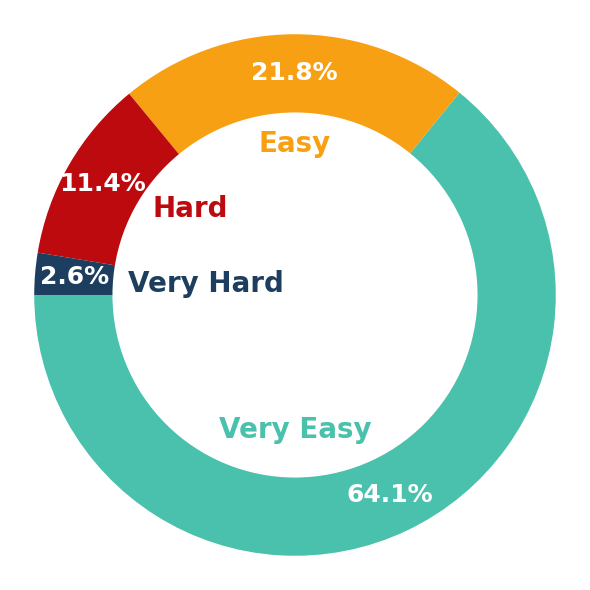

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
# Your data
word = word[word['last_difficulty'].str.strip() != '']
print(counts)
counts = word['last_difficulty'].value_counts().sort_index()
percentages = round(counts / counts.sum() * 100, 2)
#print(percentages)

# Difficulty label mapping
difficulty_labels = {
    "1": "Very Easy",
    "2": "Easy",
    "3": "Hard",
    "4": "Very Hard"
}


#colors = ['#52b7b7', '#FCA822', '#FF680A', '#B91725']
colors = ['#49C1AD', '#F7A014','#BC0A0F','#1D3E5E']
#colors = ['#B0A2A7','#FB9E09','#D13704', '#65463E']
# Get labels in order
labels = [difficulty_labels.get(str(label), str(label)) for label in percentages.index]
sizes = percentages.values

# Create figure
fig, ax = plt.subplots(figsize=(6,6))

# Create donut chart
wedges, texts, autotexts = ax.pie(sizes, labels=None, colors=colors,
                                    autopct='%1.1f%%', startangle=180,
                                    textprops={'fontsize': 18, 'weight': 'bold'},
                                    pctdistance=0.85)

label_positions = [
    (0, -0.55),   # Very Easy
    (0, 0.55),     # Easy
    (-0.4, 0.3),     # Hard
    (-0.34, 0.01)     # Very Hard
]

for i, (label, color, pos) in enumerate(zip(labels, colors, label_positions)):
    ax.annotate(label, xy=pos, fontsize=20, color=color, weight='bold', ha='center')

# Make it a donut by drawing a white circle in the center
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

for autotext in autotexts:
    autotext.set_color('white')


ax.axis('equal')
#ax.set_title("Rating Distribution for Dyslexic and Non-dyslexic Readers", fontsize=18)

plt.tight_layout()
plt.savefig("distribution_all.jpg", dpi=300, bbox_inches="tight")
plt.show()



In [18]:
word.columns

Index(['Prolific ID', 'words', 'letters', 'reason explanation',
       'letter explanation', 'date and time', 'dys-score', 'long_words',
       'diagraphs', 'not_freq_words', 'silent_letters', 'vowel_digraphs',
       'has_homophones', 'difficult_orthography', 'zipf', 'last_difficulty',
       'dyslexia'],
      dtype='object')

In [19]:
# fig, axes = plt.subplots(1, 2, figsize=(11, 6))

# color1 = ['#B3F2FC', '#8CD7E4', '#4AB8CB', '#24A3B9']
# colors2 = ['#D2E2FE', '#9EBCF9', '#6E9FFA', '#4D84FB']

# # Difficulty label mapping (both int and str keys)
# difficulty_labels = {
#     "1": "Very Easy", 1: "Very Easy",
#     "2": "Easy",      2: "Easy",
#     "3": "Hard",      3: "Hard",
#     "4": "Very Hard", 4: "Very Hard"
# }

# # Dyslexic group
# counts_dys = word_dys['last_difficulty'].value_counts().sort_index()
# axes[0].pie(
#     counts_dys.values,
#     labels=[difficulty_labels.get(label, f"Difficulty {label}") for label in counts_dys.index],
#     autopct='%1.1f%%',
#     startangle=140,
#     colors=color1,
#     textprops={'fontsize': 14, 'family': 'sans-serif'}
# )
# axes[0].axis("equal")
# axes[0].set_title("Dyslexic", fontsize=16)

# # Non-dyslexic group
# counts_notdys = word_notdys['last_difficulty'].value_counts().sort_index()
# axes[1].pie(
#     counts_notdys.values,
#     labels=[difficulty_labels.get(label, f"Difficulty {label}") for label in counts_notdys.index],
#     autopct='%1.1f%%',
#     startangle=140,
#     colors=colors2,
#     textprops={'fontsize': 14, 'family': 'sans-serif'}
# )
# axes[1].axis("equal")
# axes[1].set_title("Non-dyslexic", fontsize=16)

# plt.tight_layout()
# plt.savefig("dys-nondys-rating-distribution.jpg")
# plt.show()


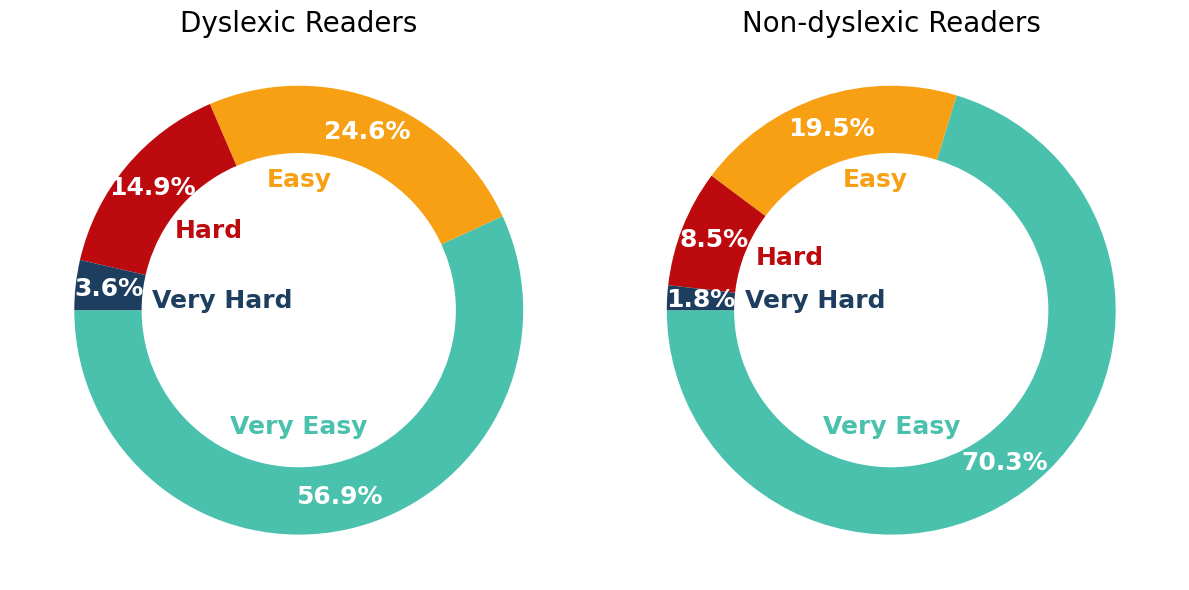

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# colors = ['#52b7b7', '#FCA822', '#FF680A', '#B91725']
colors = ['#49C1AD', '#F7A014','#BC0A0F','#1D3E5E']


# Difficulty label mapping
difficulty_labels = {
    "1": "Very Easy", 1: "Very Easy",
    "2": "Easy",      2: "Easy",
    "3": "Hard",      3: "Hard",
    "4": "Very Hard", 4: "Very Hard"
}

# Label positions for annotations (adjust as needed for each chart)
label_positions_dys = [
    (0, -0.55),   # Very Easy
    (0, 0.55),    # Easy
    (-0.4, 0.32), # Hard
    (-0.34, 0.01) # Very Hard
]

label_positions_notdys = [
    (0, -0.55),   # Very Easy
    (-0.07, 0.55),    # Easy
    (-0.45, 0.2), # Hard
    (-0.34, 0.01) # Very Hard
]

# Dyslexic group
counts_dys = word_dys['last_difficulty'].value_counts().sort_index()
percentages_dys = round(counts_dys / counts_dys.sum() * 100, 2)
labels_dys = [difficulty_labels.get(label, f"Difficulty {label}") for label in counts_dys.index]
sizes_dys = percentages_dys.values

wedges1, texts1, autotexts1 = axes[0].pie(
    sizes_dys,
    labels=None,
    colors=colors,
    autopct='%1.1f%%',
    startangle=180,
    textprops={'fontsize': 18, 'weight': 'bold'},
    pctdistance=0.85
)

# Add custom labels with annotations
for i, (label, color, pos) in enumerate(zip(labels_dys, colors, label_positions_dys)):
    axes[0].annotate(label, xy=pos, fontsize=18, color=color, weight='bold', ha='center')

# Make it a donut
centre_circle1 = plt.Circle((0, 0), 0.70, fc='white')
axes[0].add_artist(centre_circle1)

# White percentage text
for autotext in autotexts1:
    autotext.set_color('white')

axes[0].axis("equal")
axes[0].set_title("Dyslexic Readers", fontsize=20)

# Non-dyslexic group
counts_notdys = word_notdys['last_difficulty'].value_counts().sort_index()
percentages_notdys = round(counts_notdys / counts_notdys.sum() * 100, 2)
labels_notdys = [difficulty_labels.get(label, f"Difficulty {label}") for label in counts_notdys.index]
sizes_notdys = percentages_notdys.values

wedges2, texts2, autotexts2 = axes[1].pie(
    sizes_notdys,
    labels=None,
    colors=colors,
    autopct='%1.1f%%',
    startangle=180,
    textprops={'fontsize': 18, 'weight': 'bold'},
    pctdistance=0.85
)

# Add custom labels with annotations
for i, (label, color, pos) in enumerate(zip(labels_notdys, colors, label_positions_notdys)):
    axes[1].annotate(label, xy=pos, fontsize=18, color=color, weight='bold', ha='center')

# Make it a donut
centre_circle2 = plt.Circle((0, 0), 0.70, fc='white')
axes[1].add_artist(centre_circle2)

# White percentage text
for autotext in autotexts2:
    autotext.set_color('white')

axes[1].axis("equal")
axes[1].set_title("Non-dyslexic Readers", fontsize=20)

plt.tight_layout()
plt.savefig("dys-nondys-rating-distribution.jpg", dpi=300, bbox_inches="tight")
plt.show()

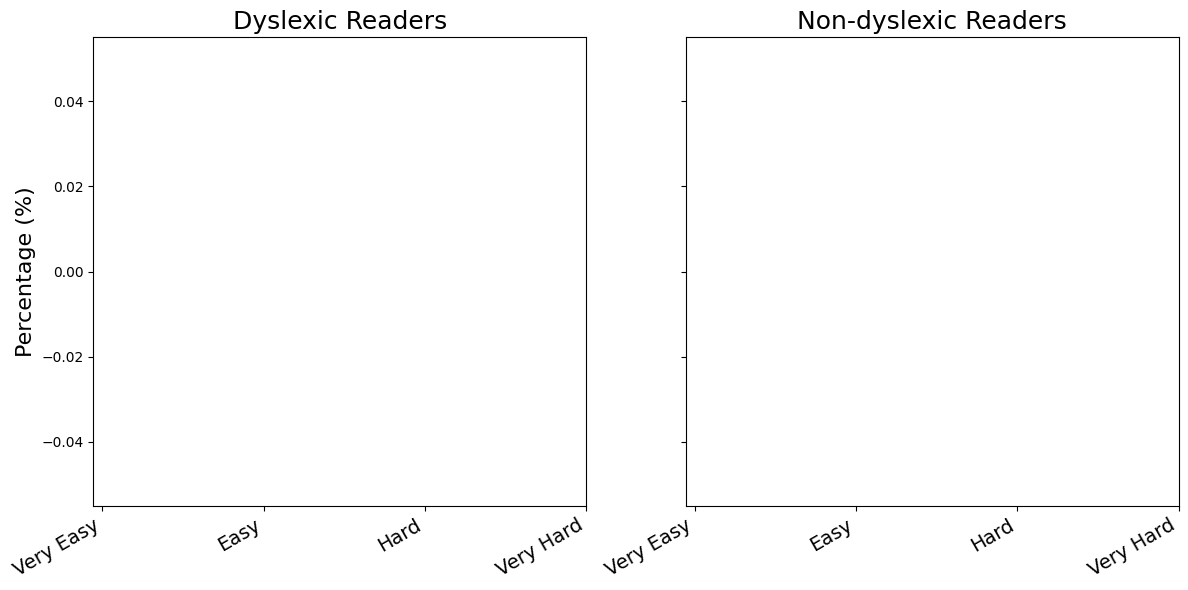

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

colors = ['#49C1AD', '#F7A014', '#BC0A0F', '#1D3E5E']

difficulty_order = [1, 2, 3, 4]
difficulty_labels = ["Very Easy", "Easy", "Hard", "Very Hard"]

# ---------- Dyslexic ----------
counts_dys = (
    word_dys['last_difficulty']
    .value_counts()
    .reindex(difficulty_order, fill_value=0)
)
perc_dys = counts_dys / counts_dys.sum() * 100

x = np.arange(len(difficulty_labels))

axes[0].bar(x, perc_dys, color=colors)
axes[0].set_xticks(x)
axes[0].set_xticklabels(difficulty_labels, rotation=30, ha='right', fontsize=14)
axes[0].set_title("Dyslexic Readers", fontsize=18)
axes[0].set_ylabel("Percentage (%)", fontsize=16)

for i, v in enumerate(perc_dys):
    axes[0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=14, weight='bold')

# ---------- Non-dyslexic ----------
counts_notdys = (
    word_notdys['last_difficulty']
    .value_counts()
    .reindex(difficulty_order, fill_value=0)
)
perc_notdys = counts_notdys / counts_notdys.sum() * 100

axes[1].bar(x, perc_notdys, color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(difficulty_labels, rotation=30, ha='right', fontsize=14)
axes[1].set_title("Non-dyslexic Readers", fontsize=18)

for i, v in enumerate(perc_notdys):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig("dys-nondys-rating-distribution-bar.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [22]:
# temp

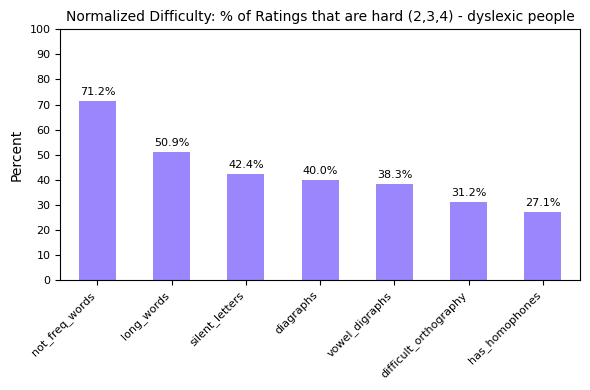

In [23]:
# not aggregated:


categories = ['long_words', 'diagraphs', 'not_freq_words',
              'silent_letters', 'vowel_digraphs', 'has_homophones',
              'difficult_orthography']

temp = word.copy()

# Clean difficulty
temp['last_difficulty_num'] = pd.to_numeric(temp['last_difficulty'].astype(str).str.strip(), errors='coerce')
temp = temp[temp['last_difficulty_num'].isin([1,2,3,4])]

# Clean feature dtypes
temp[categories] = temp[categories].fillna(0).astype(int)

# Dyslexic only
temp = temp[temp['dyslexia'] == True].copy()

# Not Very Easy = 2,3,4
not_very_easy = temp[temp['last_difficulty_num'].isin([2,3,4])]

normalized_stats = {}
for cat in categories:
    total_with_feature = (temp[cat] == 1).sum()
    not_very_easy_with_feature = (not_very_easy[cat] == 1).sum()
    normalized_stats[cat] = round(not_very_easy_with_feature / total_with_feature * 100, 2) if total_with_feature else 0

norm_dysdf = pd.DataFrame.from_dict(normalized_stats, orient='index', columns=['% Not Very Easy'])
norm_dysdf = norm_dysdf.sort_values(by='% Not Very Easy', ascending=False)


#colors = ['#84CBD7']
colors = ['#9C86FD']
ax = norm_dysdf.plot(
    kind='bar',
    legend=False,
    color=colors,
    figsize=(6, 4)
)

ax.set_title(
    "Normalized Difficulty: % of Ratings that are hard (2,3,4) - dyslexic people",
    fontdict={'fontsize': 10, 'family': 'sans-serif'}
)
ax.set_ylabel(
    "Percent",
    fontsize=10,
    fontfamily='sans-serif'
)
ax.set_xlabel("")

ax.set_ylim(0, 100)
ax.set_yticks(list(range(0, 101, 10)))
ax.tick_params(axis='y', labelsize=8)

plt.xticks(rotation=45, ha='right', fontsize=8, fontfamily='sans-serif')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.1f}%',
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=8,
        xytext=(0, 3),   # small vertical offset
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()


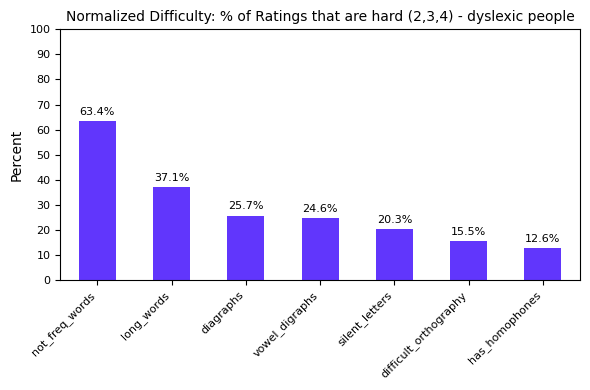

In [24]:
# not aggregated:


categories = ['long_words', 'diagraphs', 'not_freq_words',
              'silent_letters', 'vowel_digraphs', 'has_homophones',
              'difficult_orthography']

temp = word.copy()

# Clean difficulty
temp['last_difficulty_num'] = pd.to_numeric(temp['last_difficulty'].astype(str).str.strip(), errors='coerce')
temp = temp[temp['last_difficulty_num'].isin([1,2,3,4])]

# Clean feature dtypes
temp[categories] = temp[categories].fillna(0).astype(int)

# Dyslexic only
temp = temp[temp['dyslexia'] == False].copy()

# Not Very Easy = 2,3,4
not_very_easy = temp[temp['last_difficulty_num'].isin([2,3,4])]

normalized_stats = {}
for cat in categories:
    total_with_feature = (temp[cat] == 1).sum()
    not_very_easy_with_feature = (not_very_easy[cat] == 1).sum()
    normalized_stats[cat] = round(not_very_easy_with_feature / total_with_feature * 100, 2) if total_with_feature else 0

norm_nondysdf = pd.DataFrame.from_dict(normalized_stats, orient='index', columns=['% Not Very Easy'])
norm_nondysdf = norm_nondysdf.sort_values(by='% Not Very Easy', ascending=False)


#colors = ['#84CBD7']
colors = ['#6136FC']
ax = norm_nondysdf.plot(
    kind='bar',
    legend=False,
    color=colors,
    figsize=(6, 4)
)

ax.set_title(
    "Normalized Difficulty: % of Ratings that are hard (2,3,4) - dyslexic people",
    fontdict={'fontsize': 10, 'family': 'sans-serif'}
)
ax.set_ylabel(
    "Percent",
    fontsize=10,
    fontfamily='sans-serif'
)
ax.set_xlabel("")

ax.set_ylim(0, 100)
ax.set_yticks(list(range(0, 101, 10)))
ax.tick_params(axis='y', labelsize=8)

plt.xticks(rotation=45, ha='right', fontsize=8, fontfamily='sans-serif')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.1f}%',
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=8,
        xytext=(0, 3),   # small vertical offset
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()

In [25]:
short_labels = {
    'long_words': 'Long',
    'not_freq_words': 'Uncommon',
    'silent_letters': 'Silent',
    'vowel_digraphs': 'V. digraphs',
    'diagraphs': 'C. digraphs',
    'has_homophones': 'Homophones',
    'difficult_orthography': 'Difficult orth.'
}

# Apply short labels
plot_df_labeled = plot_df.copy()
plot_df_labeled.index = [short_labels.get(f, f) for f in plot_df.index]

ax = plot_df_labeled.plot(
    kind='bar',
    figsize=(8,4),
    color=['#6136FC', '#9C86FD']  # Non-dyslexic, Dyslexic
)

ax.set_title(
    "Normalized Difficulty by Word Feature (% Not Very Easy)",
    fontsize=16,
    fontfamily='sans-serif'
)
ax.set_ylabel(
    "Percent Not Very Easy",
    fontsize=10,
    fontfamily='sans-serif'
)
ax.set_xlabel("")

ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.tick_params(axis='y', labelsize=8)

# Vertical x-axis labels
plt.xticks(rotation=90, ha='center', fontsize=14, fontfamily='sans-serif')

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.1f}%',
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=12,
        xytext=(0, 3),
        textcoords='offset points',
        fontweight='bold'
    )

ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig("word_features.png", bbox_inches="tight", dpi=300)

plt.show()



NameError: name 'plot_df' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dys_color = "#6A46D8"
non_dys_color = "#A895DA"

features = ["Uncommon", "Long", "Silent", "C. digraphs", "V. digraphs", "Difficult orth.", "Homophones"]
non_dys = np.array([63.4, 37.1, 20.3, 25.7, 24.6, 15.5, 12.6])
dys     = np.array([71.2, 50.9, 42.4, 40.0, 38.3, 31.2, 27.1])

x = np.arange(len(features))

# Controls that matter
bar_w = 0.34          # bar thickness
gap = 0.02            # tiny breathing room inside the group
offset = (bar_w + gap) / 2

fig, ax = plt.subplots(figsize=(5, 3), dpi=200)

b1 = ax.bar(x - offset, non_dys, width=bar_w, label="Non-dyslexic Readers", linewidth=0.6 , color = non_dys_color)
b2 = ax.bar(x + offset, dys, width=bar_w, label="Dyslexic Readers", linewidth=0.6 , color = dys_color)

ax.set_title("Normalized Difficulty by Word Feature (% Not Very Easy)", fontsize=9)
ax.set_ylabel("Percent Not Very Easy", fontsize=7)
ax.set_ylim(0, 100)

ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90, fontsize=9)

ax.yaxis.grid(True, linestyle='-', linewidth=0.4, alpha=0.4)
ax.set_axisbelow(True)

ax.legend(loc="upper right", fontsize=6, frameon=True)

def add_labels(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2, h + 1.2,
            f"{h:.1f}",
            ha="center", va="bottom", fontsize=8 , fontweight="bold"
        )

add_labels(b1)
add_labels(b2)

# Clean spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="y", labelsize=7)

plt.tight_layout()
plt.savefig("word_features.png")
plt.show()


In [ ]:
# Normalized distribution to see what word feature rated as easy for dyslexic people

temp = word_dys.copy()


rating_counts = temp.groupby('words')['last_difficulty'].value_counts().unstack(fill_value=0)
rating_counts['total'] = rating_counts.sum(axis=1)

#add columns of 1 ,2,3,4 to a new dataset: rating_counts
rating_counts['1%'] = ((rating_counts['1'] / rating_counts['total']) * 100).round(2)
rating_counts['2%'] = ((rating_counts['2'] / rating_counts['total']) * 100).round(2)
rating_counts['3%'] = ((rating_counts['3'] / rating_counts['total']) * 100).round(2)
rating_counts['4%'] = ((rating_counts['4'] / rating_counts['total']) * 100).round(2)

rating_counts = rating_counts.merge(temp[['words','long_words', 'diagraphs', 'not_freq_words', 'silent_letters', 'vowel_digraphs','has_homophones', 'difficult_orthography']], on='words', how='left')
rating_counts.drop_duplicates(subset='words', keep='first', inplace=True)
# print(rating_counts.shape)
# filter out the words that are rated as very easy with the higher rate than 80% and creating 2 new datasets: difficult_words, easy_words
difficult_words = rating_counts[
    ((rating_counts['total'] < 5) & (rating_counts['1']/ rating_counts['total']< 0.75)) |
    ((rating_counts['total'] >= 5) & (rating_counts['1'] / rating_counts['total'] < 0.8))
]
dys_difficult_list = difficult_words['words'].to_list()
# print(dys_difficult_list)

easy_words = rating_counts[
    ((rating_counts['total'] < 5) & (rating_counts['1']/ rating_counts['total']>= 0.75)) |
    ((rating_counts['total'] >= 5) & (rating_counts['1'] / rating_counts['total'] >= 0.8))
]

# print(rating_counts.shape,difficult_words.shape, easy_words.shape)

# Normalized distribution to see what word feature is the hardest(2,3,4) -  dyslexic people
categories = ['long_words', 'diagraphs', 'not_freq_words',
              'silent_letters', 'vowel_digraphs', 'has_homophones',
              'difficult_orthography']

normalized_stats = {}

for cat in categories:
    total_with_feature = rating_counts[rating_counts[cat] == 1].shape[0]
    difficult_with_feature = difficult_words[difficult_words[cat] == 1].shape[0]

    if total_with_feature > 0:
        normalized_stats[cat] = round(difficult_with_feature / total_with_feature * 100, 2)
    else:
        normalized_stats[cat] = 0

norm_dysdf = pd.DataFrame.from_dict(normalized_stats, orient='index', columns=['% Hard Ratings'])
norm_dysdf = norm_dysdf.sort_values(by='% Hard Ratings', ascending=False)





In [ ]:
# Normalized distribution to see what word feature rated as easy for non-dyslexic people
#print('shape', word_notdys.shape)

temp = word_notdys.copy()

rating_counts = temp.groupby('words')['last_difficulty'].value_counts().unstack(fill_value=0)
rating_counts['total'] = rating_counts.sum(axis=1)

#add columns of 1 ,2,3,4 to a new dataset: rating_counts
rating_counts['1%'] = ((rating_counts['1'] / rating_counts['total']) * 100).round(2)
rating_counts['2%'] = ((rating_counts['2'] / rating_counts['total']) * 100).round(2)
rating_counts['3%'] = ((rating_counts['3'] / rating_counts['total']) * 100).round(2)
rating_counts['4%'] = ((rating_counts['4'] / rating_counts['total']) * 100).round(2)

rating_counts = rating_counts.merge(temp[['words','long_words', 'diagraphs', 'not_freq_words', 'silent_letters', 'vowel_digraphs','has_homophones', 'difficult_orthography']], on='words', how='left')

rating_counts.drop_duplicates(subset='words', keep='first', inplace=True)

# filter out the words that are rated as very easy with the higher rate than 80% and creating 2 new datasets: difficult_words, easy_words
difficult_words = rating_counts[
    ((rating_counts['total'] < 5) & (rating_counts['1']/ rating_counts['total']< 0.75)) |
    ((rating_counts['total'] >= 5) & (rating_counts['1'] / rating_counts['total'] < 0.8))
]
nondys_difficult_list = difficult_words['words'].to_list()

easy_words = rating_counts[
    ((rating_counts['total'] < 5) & (rating_counts['1']/ rating_counts['total']>= 0.75)) |
    ((rating_counts['total'] >= 5) & (rating_counts['1'] / rating_counts['total'] >= 0.8))
]


# Normalized distribution to see what word feature is the hardest - non dyslexic people
categories = ['long_words', 'diagraphs', 'not_freq_words',
              'silent_letters', 'vowel_digraphs', 'has_homophones',
              'difficult_orthography']

normalized_stats = {}

for cat in categories:
    total_with_feature = rating_counts[rating_counts[cat] == 1].shape[0]
    difficult_with_feature = difficult_words[difficult_words[cat] == 1].shape[0]

    if total_with_feature > 0:
        normalized_stats[cat] = round(difficult_with_feature / total_with_feature * 100, 2)
    else:
        normalized_stats[cat] = 0

norm_nondysdf = pd.DataFrame.from_dict(normalized_stats, orient='index', columns=['% Hard Ratings'])
norm_nondysdf = norm_nondysdf.sort_values(by='% Hard Ratings', ascending=False)





# XGBOOST

In [ ]:
word['dys hard'] = (word['words'].isin(dys_difficult_list)) & (word['dyslexia']==True).astype(int)
word['nondys hard'] = (word['words'].isin(nondys_difficult_list)) & (word['dyslexia']==False).astype(int)



In [ ]:
dys_word = word[word['dyslexia']==True]
nondys_word = word[word['dyslexia']==False]

dys_word = dys_word.drop(columns=['nondys hard'])
nondys_word = nondys_word.drop(columns=['dys hard'])


dys_word['dys hard'] = dys_word['dys hard'].astype(int)
nondys_word['nondys hard'] = nondys_word['nondys hard'].astype(int)


In [ ]:
# XGBoost - seperate datasets - only zipf and long word


# remove some columns
# dys_word1 = dys_word.drop(columns=['Prolific ID', 'words', 'letters', 'date and time', 'dys-score', 'last_difficulty','not_freq_words','dyslexia', 'diagraphs', 'not_freq_words', 'silent_letters', 'vowel_digraphs', 'has_homophones', 'difficult_orthography'])
# nondys_word1 = nondys_word.drop(columns=['Prolific ID', 'words', 'letters', 'date and time', 'dys-score', 'last_difficulty', 'not_freq_words','dyslexia', 'diagraphs', 'not_freq_words', 'silent_letters','vowel_digraphs', 'has_homophones', 'difficult_orthography'])
# dys_word1 = dys_word.drop(columns=['zipf'])
# nondys_word1 = nondys_word.drop(columns=['zipf'])
# dys_word1

# Dyslexic dataset
# X_dys = dys_word1.drop(columns=['dys hard'])
# y_dys = dys_word1['dys hard']

# X_train_dys, X_test_dys, y_train_dys, y_test_dys = train_test_split(X_dys, y_dys, test_size=0.2, random_state=42)

# model_dys = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# model_dys.fit(X_train_dys, y_train_dys)

# y_pred_dys = model_dys.predict(X_test_dys)
# print("Accuracy (Dyslexic):", accuracy_score(y_test_dys, y_pred_dys))

# #  Non-dyslexic dataset
# X_nondys = nondys_word1.drop(columns=['nondys hard'])
# y_nondys = nondys_word1['nondys hard']

# X_train_nondys, X_test_nondys, y_train_nondys, y_test_nondys = train_test_split(X_nondys, y_nondys, test_size=0.2, random_state=42)

# model_nondys = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# model_nondys.fit(X_train_nondys, y_train_nondys)

# y_pred_nondys = model_nondys.predict(X_test_nondys)
# print("Accuracy (Non-Dyslexic):", accuracy_score(y_test_nondys, y_pred_nondys))


In [ ]:
#CV - baseline

scoring = {
    "acc": "accuracy",
    "f1": "f1",
    "roc": "roc_auc",
    "pr": "average_precision",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = xgb.XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    random_state=42
)

# Dyslexic
res_dys = cross_validate(clf, X_dys, y_dys, cv=cv, scoring=scoring, n_jobs=-1)
print("Dyslexic (5-fold):",
      f"Acc {np.mean(res_dys['test_acc']):.3f}",
      f"F1 {np.mean(res_dys['test_f1']):.3f}",
      f"ROC {np.mean(res_dys['test_roc']):.3f}",
      f"PR {np.mean(res_dys['test_pr']):.3f}")

# Non-dyslexic
res_nondys = cross_validate(clf, X_nondys, y_nondys, cv=cv, scoring=scoring, n_jobs=-1)
print("Non-dyslexic (5-fold):",
      f"Acc {np.mean(res_nondys['test_acc']):.3f}",
      f"F1 {np.mean(res_nondys['test_f1']):.3f}",
      f"ROC {np.mean(res_nondys['test_roc']):.3f}",
      f"PR {np.mean(res_nondys['test_pr']):.3f}")


def mean_std(arr):
    return f"{np.mean(arr):.3f} ± {np.std(arr):.3f}"

print("Dyslexic (5-fold):",
      f"Acc {mean_std(res_dys['test_acc'])}",
      f"F1 {mean_std(res_dys['test_f1'])}",
      f"ROC {mean_std(res_dys['test_roc'])}",
      f"PR {mean_std(res_dys['test_pr'])}")

print("Non-dyslexic (5-fold):",
      f"Acc {mean_std(res_nondys['test_acc'])}",
      f"F1 {mean_std(res_nondys['test_f1'])}",
      f"ROC {mean_std(res_nondys['test_roc'])}",
      f"PR {mean_std(res_nondys['test_pr'])}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 407, in pandas_feature_info
    new_feature_types.append(_pandas_dtype_mapper[dtype.name])
                             ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'object'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1787, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 702, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1257, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 1768, in __init__
    self._init(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 1832, in _init
    it.reraise()
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 617, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 598, in _handle_exception
    return fn()
           ^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 685, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
                                              ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 1632, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 665, in input_data
    new, feature_names, feature_types = _proxy_transform(
                                        ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 1685, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
                                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 662, in _transform_pandas_df
    feature_names, feature_types = pandas_feature_info(
                                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 409, in pandas_feature_info
    _invalid_dataframe_dtype(data)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 372, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Prolific ID: object, words: object, letters: object, reason explanation: object, letter explanation: object, date and time: datetime64[ns], last_difficulty: object


In [ ]:
dys_word.columns

Index(['Prolific ID', 'words', 'letters', 'reason explanation',
       'letter explanation', 'date and time', 'dys-score', 'long_words',
       'diagraphs', 'not_freq_words', 'silent_letters', 'vowel_digraphs',
       'has_homophones', 'difficult_orthography', 'zipf', 'last_difficulty',
       'dyslexia', 'dys hard'],
      dtype='object')

In [ ]:
# XGBoost - seperate datasets

dys_word['dys hard'] = dys_word['dys hard'].astype(int)
nondys_word['nondys hard'] = nondys_word['nondys hard'].astype(int)



# remove some columns
dys_word = dys_word.drop(columns=['Prolific ID', 'words', 'letters', 'date and time', 'dys-score', 'last_difficulty','not_freq_words','dyslexia','reason explanation', 'letter explanation'])
nondys_word = nondys_word.drop(columns=['Prolific ID', 'words', 'letters', 'date and time', 'dys-score', 'last_difficulty', 'not_freq_words','dyslexia','reason explanation', 'letter explanation'])
# # Dyslexic dataset
# X_dys = dys_word.drop(columns=['dys hard'])
# y_dys = dys_word['dys hard']

# X_train_dys, X_test_dys, y_train_dys, y_test_dys = train_test_split(X_dys, y_dys, test_size=0.2, random_state=42)

# model_dys = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# model_dys.fit(X_train_dys, y_train_dys)

# y_pred_dys = model_dys.predict(X_test_dys)
# print("Accuracy (Dyslexic):", accuracy_score(y_test_dys, y_pred_dys))

# #  Non-dyslexic dataset
# X_nondys = nondys_word.drop(columns=['nondys hard'])
# y_nondys = nondys_word['nondys hard']

# X_train_nondys, X_test_nondys, y_train_nondys, y_test_nondys = train_test_split(X_nondys, y_nondys, test_size=0.2, random_state=42)

# model_nondys = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# model_nondys.fit(X_train_nondys, y_train_nondys)

# y_pred_nondys = model_nondys.predict(X_test_nondys)
# print("Accuracy (Non-Dyslexic):", accuracy_score(y_test_nondys, y_pred_nondys))


KeyError: "['Prolific ID', 'words', 'letters', 'date and time', 'dys-score', 'last_difficulty', 'not_freq_words', 'dyslexia', 'reason explanation', 'letter explanation'] not found in axis"

In [ ]:
dys_word


,long_words,diagraphs,silent_letters,vowel_digraphs,has_homophones,difficult_orthography,zipf,dys hard
0,1.0,0.0,0.0,0.0,0.0,0.0,5.01,1
1,1.0,0.0,0.0,1.0,0.0,0.0,2.85,1
2,1.0,1.0,0.0,0.0,0.0,0.0,3.96,1
3,NaN,NaN,NaN,NaN,NaN,NaN,3.87,1
4,1.0,0.0,0.0,1.0,0.0,0.0,2.51,1
...,...,...,...,...,...,...,...,...
4986,1.0,0.0,0.0,0.0,0.0,0.0,4.95,1
4987,NaN,NaN,NaN,NaN,NaN,NaN,4.40,1
4988,1.0,0.0,0.0,0.0,0.0,0.0,4.36,1
4989,0.0,0.0,0.0,0.0,1.0,0.0,4.29,1


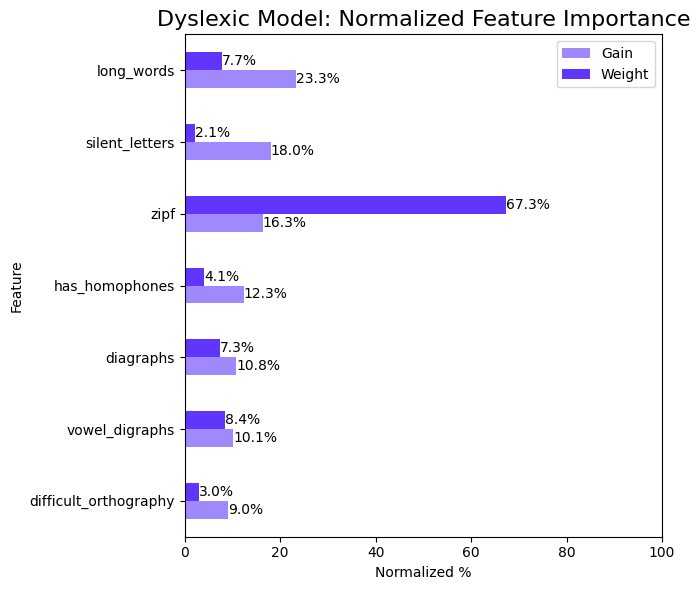

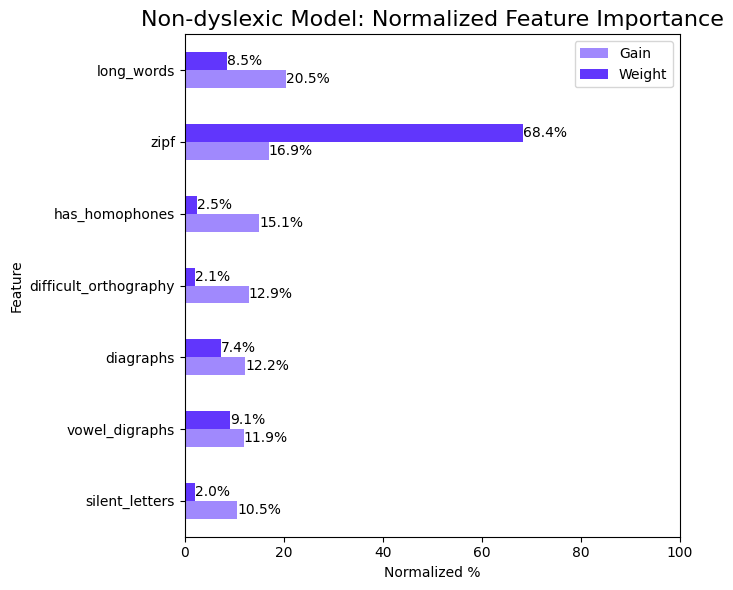

In [ ]:
def add_bar_labels(ax, fmt="{:.1f}%"):
    for container in ax.containers:
        for bar in container:
            width = bar.get_width()
            if width > 0:
                ax.text(
                    width,
                    bar.get_y() + bar.get_height()/2,
                    fmt.format(width),
                    va="center",
                    ha="left",
                    fontsize=10
                )


# For dyslexic model

importance_dys_gain = model_dys.get_booster().get_score(importance_type='gain')
importance_dys_weight = model_dys.get_booster().get_score(importance_type='weight')
importance_dys_cover = model_dys.get_booster().get_score(importance_type='cover')

# For non-dyslexic model
importance_nondys_gain = model_nondys.get_booster().get_score(importance_type='gain')
importance_nondys_weight = model_nondys.get_booster().get_score(importance_type='weight')
importance_nondys_cover = model_nondys.get_booster().get_score(importance_type='cover')

def normalize_importance(gain_dict, weight_dict):
    gain_df = pd.DataFrame(list(gain_dict.items()), columns=['Feature', 'Gain'])
    weight_df = pd.DataFrame(list(weight_dict.items()), columns=['Feature', 'Weight'])
    df = pd.merge(gain_df, weight_df, on="Feature", how="outer").fillna(0)

    df['Gain'] = df['Gain'] / df['Gain'].sum() * 100
    df['Weight'] = df['Weight'] / df['Weight'].sum() * 100

    return df.set_index("Feature")

df_dys = normalize_importance(importance_dys_gain, importance_dys_weight)
df_nondys = normalize_importance(importance_nondys_gain, importance_nondys_weight)



#  dyslexic
colors = ["#A089FD", "#6136FC"]
ax = df_dys[['Gain','Weight']].sort_values('Gain').plot(
    kind="barh", figsize=(7,6), color=colors
)
ax.set_title("Dyslexic Model: Normalized Feature Importance",
             fontdict={'fontsize': 16, 'family': 'sans-serif'})
ax.set_xlabel("Normalized %", fontsize=10, fontfamily='sans-serif')
ax.legend(["Gain", "Weight"], fontsize=10)
add_bar_labels(ax)
plt.tight_layout()
ax.set_xlim(0, 100)
plt.show()

# non-dyslexic
colors_right = ["#A089FD", "#6136FC"]
ax = df_nondys[['Gain','Weight']].sort_values('Gain').plot(
    kind="barh", figsize=(7,6), color=colors
)
ax.set_title("Non-dyslexic Model: Normalized Feature Importance",
             fontdict={'fontsize': 16, 'family': 'sans-serif'})
ax.set_xlabel("Normalized %", fontsize=10, fontfamily='sans-serif')
ax.legend(["Gain", "Weight"], fontsize=10)
plt.tight_layout()
add_bar_labels(ax)
plt.savefig("informationGain.png", bbox_inches="tight", dpi=300)
ax.set_xlim(0, 100)
plt.show()



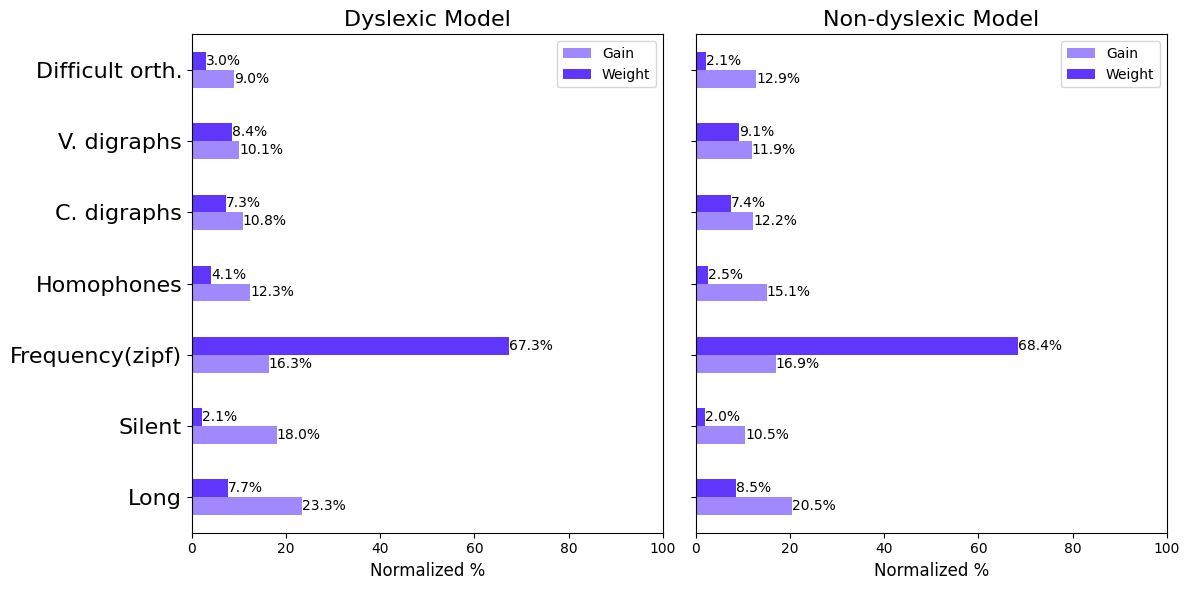

In [ ]:
importance_dys_gain   = model_dys.get_booster().get_score(importance_type='gain')
importance_dys_weight = model_dys.get_booster().get_score(importance_type='weight')
importance_dys_cover  = model_dys.get_booster().get_score(importance_type='cover')

importance_nondys_gain   = model_nondys.get_booster().get_score(importance_type='gain')
importance_nondys_weight = model_nondys.get_booster().get_score(importance_type='weight')
importance_nondys_cover  = model_nondys.get_booster().get_score(importance_type='cover')

def normalize_importance(gain_dict, weight_dict):
    gain_df = pd.DataFrame(list(gain_dict.items()), columns=['Feature', 'Gain'])
    weight_df = pd.DataFrame(list(weight_dict.items()), columns=['Feature', 'Weight'])
    df = pd.merge(gain_df, weight_df, on="Feature", how="outer").fillna(0)
    df['Gain']   = df['Gain']   / df['Gain'].sum()   * 100
    df['Weight'] = df['Weight'] / df['Weight'].sum() * 100
    return df.set_index("Feature")

df_dys    = normalize_importance(importance_dys_gain,    importance_dys_weight)
df_nondys = normalize_importance(importance_nondys_gain, importance_nondys_weight)

dys_order = df_dys.sort_values('Gain', ascending=False).index.tolist()
common_order = dys_order + [f for f in df_nondys.index if f not in dys_order]
df_dys_aligned    = df_dys.reindex(common_order).fillna(0)
df_nondys_aligned = df_nondys.reindex(common_order).fillna(0)

short_labels = {
    'long_words': 'Long',
    'zipf': 'Frequency(zipf)',
    'silent_letters': 'Silent',
    'vowel_digraphs': 'V. digraphs',
    'diagraphs': 'C. digraphs',
    'has_homophones': 'Homophones',
    'difficult_orthography': 'Difficult orth.'
}
# Dyslexic
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for ax in axes:
    ax.set_yticklabels([lbl.get_text() for lbl in ax.get_yticklabels()],
                       fontdict={ 'size': 16})
colors = ["#A089FD", "#6136FC"]
df_dys_plt = df_dys_aligned.rename(index=short_labels)
df_dys_plt[['Gain', 'Weight']].plot(kind="barh", color=colors, ax=axes[0])
axes[0].set_title("Dyslexic Model",
                  fontdict={'fontsize': 16, 'family': 'sans-serif'})
axes[0].set_xlabel("Normalized %", fontsize=12, fontfamily='sans-serif')
axes[0].legend(["Gain", "Weight"], fontsize=10)


# Non-dyslexic
colors = ["#A089FD", "#6136FC"]
df_nd_plt = df_nondys_aligned.rename(index=short_labels)
df_nd_plt[['Gain', 'Weight']].plot(kind="barh", color=colors, ax=axes[1])
axes[1].set_title("Non-dyslexic Model",
                  fontdict={'fontsize': 16, 'family': 'sans-serif'})
axes[1].set_xlabel("Normalized %", fontsize=12, fontfamily='sans-serif')
axes[1].legend(["Gain", "Weight"], fontsize=10)

max_x = max(df_dys_aligned[['Gain','Weight']].to_numpy().max(),
            df_nondys_aligned[['Gain','Weight']].to_numpy().max())
axes[0].set_xlim(0, 100)
axes[1].set_xlim(0, 100)
add_bar_labels(axes[1])
add_bar_labels(axes[0])
df_dys_plt.index.name = None
df_nd_plt.index.name = None
axes[0].set_ylabel("")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("informationGain.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
scoring = {
    "acc": "accuracy",
    "f1": "f1",
    "roc": "roc_auc",
    "pr": "average_precision",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = xgb.XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    random_state=42
)

# Dyslexic
res_dys = cross_validate(clf, X_dys, y_dys, cv=cv, scoring=scoring, n_jobs=-1)
print("Dyslexic (5-fold):",
      f"Acc {np.mean(res_dys['test_acc']):.3f}",
      f"F1 {np.mean(res_dys['test_f1']):.3f}",
      f"ROC {np.mean(res_dys['test_roc']):.3f}",
      f"PR {np.mean(res_dys['test_pr']):.3f}")

# Non-dyslexic
res_nondys = cross_validate(clf, X_nondys, y_nondys, cv=cv, scoring=scoring, n_jobs=-1)
print("Non-dyslexic (5-fold):",
      f"Acc {np.mean(res_nondys['test_acc']):.3f}",
      f"F1 {np.mean(res_nondys['test_f1']):.3f}",
      f"ROC {np.mean(res_nondys['test_roc']):.3f}",
      f"PR {np.mean(res_nondys['test_pr']):.3f}")


def mean_std(arr):
    return f"{np.mean(arr):.3f} ± {np.std(arr):.3f}"

print("Dyslexic (5-fold):",
      f"Acc {mean_std(res_dys['test_acc'])}",
      f"F1 {mean_std(res_dys['test_f1'])}",
      f"ROC {mean_std(res_dys['test_roc'])}",
      f"PR {mean_std(res_dys['test_pr'])}")

print("Non-dyslexic (5-fold):",
      f"Acc {mean_std(res_nondys['test_acc'])}",
      f"F1 {mean_std(res_nondys['test_f1'])}",
      f"ROC {mean_std(res_nondys['test_roc'])}",
      f"PR {mean_std(res_nondys['test_pr'])}")



In [ ]:
def plot_cv_curves(X, y, model, n_splits=5, title=""):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    tprs, aucs, mean_fpr = [], [], np.linspace(0, 1, 100)
    precisions, recalls, pr_aucs = [], [], []

    fig, axes = plt.subplots(1, 2, figsize=(9,4))

    for train, test in cv.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        proba = model.predict_proba(X.iloc[test])[:, 1]

        fpr, tpr, _ = roc_curve(y.iloc[test], proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        axes[0].plot(fpr, tpr, lw=1, alpha=0.5, label=f'Fold AUC={roc_auc:.2f}')

        prec, rec, _ = precision_recall_curve(y.iloc[test], proba)
        pr_auc = average_precision_score(y.iloc[test], proba)
        pr_aucs.append(pr_auc)
        precisions.append(np.interp(np.linspace(0,1,100), rec[::-1], prec[::-1]))
        recalls.append(np.linspace(0,1,100))
        axes[1].plot(rec, prec, lw=1, alpha=0.5, label=f'Fold AP={pr_auc:.2f}')

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    axes[0].plot(mean_fpr, mean_tpr, color='b',
                 label=f'Mean ROC AUC={mean_auc:.2f}', lw=2)
    axes[0].plot([0,1],[0,1],'--', color='gray')
    axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title="ROC Curve")
    axes[0].legend()

    mean_prec = np.mean(precisions, axis=0)
    mean_pr_auc = np.mean(pr_aucs)
    axes[1].plot(np.linspace(0,1,100), mean_prec, color='b',
                 label=f'Mean PR AUC={mean_pr_auc:.2f}', lw=2)
    axes[1].set(xlabel='Recall', ylabel='Precision', title="Precision-Recall Curve")
    axes[1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", bbox_inches="tight", dpi=300)
    plt.show()


clf = xgb.XGBClassifier(tree_method="hist", eval_metric="logloss", random_state=42)

plot_cv_curves(X_dys, y_dys, clf, title="dyslexic (5-fold CV)")
clf = xgb.XGBClassifier(tree_method="hist", eval_metric="logloss", random_state=42)

plot_cv_curves(X_nondys, y_nondys, clf, title="Non-dyslexic (5-fold CV)")

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

def plot_cv_curves_on_axes(X, y, model, axes, n_splits=5, title=""):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    mean_fpr = np.linspace(0, 1, 100)
    mean_rec = np.linspace(0, 1, 100)

    tprs, aucs = [], []
    precs, pr_aucs = [], []

    for train, test in cv.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        proba = model.predict_proba(X.iloc[test])[:, 1]

        # ROC
        fpr, tpr, _ = roc_curve(y.iloc[test], proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        axes[0].plot(fpr, tpr, lw=1, alpha=0.4)

        # PR
        prec, rec, _ = precision_recall_curve(y.iloc[test], proba)
        pr_auc = average_precision_score(y.iloc[test], proba)
        pr_aucs.append(pr_auc)
        precs.append(np.interp(mean_rec, rec[::-1], prec[::-1]))
        axes[1].plot(rec, prec, lw=1, alpha=0.4)

    # Mean ROC
    axes[0].plot(mean_fpr, np.mean(tprs, axis=0),
                 lw=2, label=f"Mean AUC={np.mean(aucs):.2f}")
    axes[0].plot([0,1],[0,1],'--', color='gray')
    axes[0].set(title=f"{title} – ROC",
                xlabel="False Positive Rate",
                ylabel="True Positive Rate")
    axes[0].legend()

    # Mean PR
    axes[1].plot(mean_rec, np.mean(precs, axis=0),
                 lw=2, label=f"Mean AP={np.mean(pr_aucs):.2f}")
    axes[1].set(title=f"{title} – Precision–Recall",
                xlabel="Recall",
                ylabel="Precision")
    axes[1].legend()



In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Dyslexic (LEFT column)
clf_dys = xgb.XGBClassifier(tree_method="hist",
                            eval_metric="logloss",
                            random_state=42)

plot_cv_curves_on_axes(
    X_dys, y_dys, clf_dys,
    axes=[axes[0,0], axes[0,1]],
    title="Dyslexic"
)

# Non-dyslexic (RIGHT column)
clf_nondys = xgb.XGBClassifier(tree_method="hist",
                               eval_metric="logloss",
                               random_state=42)

plot_cv_curves_on_axes(
    X_nondys, y_nondys, clf_nondys,
    axes=[axes[1,0], axes[1,1]],
    title="Non-dyslexic"
)

plt.tight_layout()
plt.savefig("cv_curves_dys_vs_nondys.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dys_color = "#99a1eb"
non_dys_color = "#4552D9"

features = [
    "Frequency(zipf)",
    "Long",
    "Silent",
    "Homophones",
    "C. digraphs",
    "V. digraphs",
    "Difficult orth."
]

y = np.arange(len(features))

# These are already percentages (do NOT normalize)
dys_gain       = np.array([16.3, 23.3, 18.0, 12.3, 10.8, 10.1, 9.0])
dys_weight     = np.array([67.3, 7.7,  2.1,  4.1,  7.3,  8.4, 3.0])

nondys_gain    = np.array([16.9, 20.5, 10.5, 15.1, 12.2, 11.9, 12.9])
nondys_weight  = np.array([68.4, 8.5,  2.0,  2.5,  7.4,  9.1, 2.1])

teacher_gain   = np.array([11.1, 33.1, 5.0, 10.0, 8.1, 7.6, 11.4])
teacher_weight = np.array([58.3, 8.5,  4.3,  4.9, 8.3, 9.1, 3.8])

panels = [
    ("Dyslexic Model", dys_gain, dys_weight),
    ("Non-dyslexic Model", nondys_gain, nondys_weight),
    ("Teacher Model", teacher_gain, teacher_weight)
]

fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=200, sharey=True)

bar_h = 0.32
gap = 0.03
offset = (bar_h + gap) / 2

for ax, (title, gain, weight) in zip(axes, panels):

    b1 = ax.barh(y + offset, gain, height=bar_h, color=non_dys_color, label="Gain")
    b2 = ax.barh(y - offset, weight, height=bar_h, color=dys_color, label="Weight")

    ax.set_title(title, fontsize=8)
    ax.set_xlim(0, 80)
    ax.set_xlabel("Normalized %", fontsize=7)

    ax.xaxis.grid(True, linestyle='-', linewidth=0.4, alpha=0.4)
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", labelsize=7)

    # Exact labels (these will now match your arrays)
    for bars in (b1, b2):
        for bar in bars:
            w = bar.get_width()
            ax.text(
                w + 1.2,
                bar.get_y() + bar.get_height()/2,
                f"{w:.1f}",
                va="center",
                ha="left",
                fontsize=7,
                fontweight="bold"
            )

    ax.legend(loc="upper right", fontsize=6, frameon=True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Feature labels only on first panel
axes[0].set_yticks(y)
axes[0].set_yticklabels(features, fontsize=7)

for ax in axes[1:]:
    ax.set_yticks(y)
    ax.set_yticklabels([])
axes[0].set_yticklabels(features, fontsize=7)

plt.tight_layout(pad=0.6)
plt.savefig("xgb_importance_panels.png", bbox_inches="tight")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Statistical analysis

In [26]:
# Inferential
dys_ratings = word[word['dyslexia']==1]
nondys_ratings = word[word['dyslexia']==0]
nondys_ratings['Prolific ID'].nunique(), dys_ratings["Prolific ID"].nunique()

(102, 78)

In [27]:
df = word.copy()

In [28]:
dys_ratings = word[word['dyslexia']==1]
nondys_ratings = word[word['dyslexia']==0]
nondys_ratings['Prolific ID'].nunique(), dys_ratings["Prolific ID"].nunique()

(102, 78)

In [29]:

from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

features = [
    'long_words', 'diagraphs', 'not_freq_words',
    'silent_letters', 'vowel_digraphs', 'has_homophones',
    'difficult_orthography'
]

df = word.copy()


df['last_difficulty_num'] = pd.to_numeric(df['last_difficulty'].astype(str).str.strip(), errors='coerce')
df = df[df['last_difficulty_num'].isin([1,2,3,4])]


df['binary'] = np.where(df['last_difficulty_num'] == 1, 'Very Easy', 'Not Very Easy')

df[features] = df[features].fillna(0).astype(int)

results = []

for feat in features:
    df_feat = df[df[feat] == 1].copy()

    table = pd.crosstab(df_feat['dyslexia'], df_feat['binary'])
    table = table.reindex(index=[True, False], columns=['Not Very Easy', 'Very Easy'], fill_value=0)

    # Fisher exact needs [[a,b],[c,d]] in numeric array
    odds_ratio, p_value = fisher_exact(table.values)


    # Compare odds of Not Very Easy (dys vs non)
    # odds = (NotVeryEasy/VeryEasy)
    a, b = table.loc[True,  'Not Very Easy'], table.loc[True,  'Very Easy']
    c, d = table.loc[False, 'Not Very Easy'], table.loc[False, 'Very Easy']

    dys_odds = (a / b) if b != 0 else np.inf
    non_odds = (c / d) if d != 0 else np.inf
    direction = "Dys higher Not Very Easy" if dys_odds > non_odds else "Non higher Not Very Easy"

    results.append({
        "feature": feat,
        "dys_NotVeryEasy": int(a),
        "dys_VeryEasy": int(b),
        "non_NotVeryEasy": int(c),
        "non_VeryEasy": int(d),
        "odds_ratio": odds_ratio,
        "p_raw": p_value,
        "direction": direction
    })

res = pd.DataFrame(results)

# FDR correction (Benjamini-Hochberg)
res["p_fdr"] = multipletests(res["p_raw"], method="fdr_bh")[1]
res["significant_fdr_0.05"] = res["p_fdr"] < 0.05

# sort by p
res = res.sort_values("p_fdr")

res


,feature,dys_NotVeryEasy,dys_VeryEasy,non_NotVeryEasy,non_VeryEasy,odds_ratio,p_raw,direction,p_fdr,significant_fdr_0.05
0,long_words,1448,1397,1246,2113,1.757736,9.575321e-28,Dys higher Not Very Easy,6.702724e-27,True
4,vowel_digraphs,615,991,459,1407,1.902317,3.996673e-18,Dys higher Not Very Easy,1.398836e-17,True
1,diagraphs,448,673,343,991,1.923280,5.618175e-14,Dys higher Not Very Easy,1.310907e-13,True
5,has_homophones,104,280,59,408,2.568523,1.195005e-07,Dys higher Not Very Easy,2.091259e-07,True
3,silent_letters,84,114,41,161,2.893453,1.875736e-06,Dys higher Not Very Easy,2.626030e-06,True
6,difficult_orthography,60,132,40,218,2.477273,8.989492e-05,Dys higher Not Very Easy,1.048774e-04,True
2,not_freq_words,503,203,576,333,1.432497,9.502201e-04,Dys higher Not Very Easy,9.502201e-04,True


In [30]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

features = [
    'long_words', 'diagraphs', 'not_freq_words',
    'silent_letters', 'vowel_digraphs', 'has_homophones',
    'difficult_orthography'
]

df = word.copy()

df['last_difficulty_num'] = pd.to_numeric(df['last_difficulty'].astype(str).str.strip(), errors='coerce')
df = df[df['last_difficulty_num'].isin([1,2,3,4])]

df['binary'] = np.where(df['last_difficulty_num'] == 1, 'Very Easy', 'Not Very Easy')
df[features] = df[features].fillna(0).astype(int)

results = []

Z = 1.96  # 95% CI

for feat in features:
    df_feat = df[df[feat] == 1].copy()

    table = pd.crosstab(df_feat['dyslexia'], df_feat['binary'])
    table = table.reindex(index=[True, False], columns=['Not Very Easy', 'Very Easy'], fill_value=0)

    # counts
    a = int(table.loc[True,  'Not Very Easy'])
    b = int(table.loc[True,  'Very Easy'])
    c = int(table.loc[False, 'Not Very Easy'])
    d = int(table.loc[False, 'Very Easy'])

    # Fisher exact p-value + OR
    odds_ratio, p_value = fisher_exact([[a, b], [c, d]])

    # direction (avoid divide-by-zero -> use corrected odds when needed)
    if b == 0 or d == 0:
        dys_odds = (a + 0.5) / (b + 0.5)
        non_odds = (c + 0.5) / (d + 0.5)
    else:
        dys_odds = a / b
        non_odds = c / d
    direction = "Dys higher Not Very Easy" if dys_odds > non_odds else "Non higher Not Very Easy"

    # ----- 95% CI for OR -----
    # If any cell is zero, apply Haldane–Anscombe correction to compute CI.
    if (a == 0) or (b == 0) or (c == 0) or (d == 0):
        a_ci, b_ci, c_ci, d_ci = a + 0.5, b + 0.5, c + 0.5, d + 0.5
    else:
        a_ci, b_ci, c_ci, d_ci = float(a), float(b), float(c), float(d)

    # log(OR) and SE
    or_ci = (a_ci * d_ci) / (b_ci * c_ci)
    se = np.sqrt(1/a_ci + 1/b_ci + 1/c_ci + 1/d_ci)
    log_or = np.log(or_ci)

    ci_low = np.exp(log_or - Z * se)
    ci_high = np.exp(log_or + Z * se)

    results.append({
        "feature": feat,
        "dys_NotVeryEasy": a,
        "dys_VeryEasy": b,
        "non_NotVeryEasy": c,
        "non_VeryEasy": d,
        "odds_ratio": odds_ratio,
        "ci95_low": ci_low,
        "ci95_high": ci_high,
        "p_raw": p_value,
        "direction": direction
    })

res = pd.DataFrame(results)

# FDR correction (Benjamini-Hochberg)
res["p_fdr"] = multipletests(res["p_raw"], method="fdr_bh")[1]
res["significant_fdr_0.05"] = res["p_fdr"] < 0.05

# sort by adjusted p
res = res.sort_values("p_fdr")

res


,feature,dys_NotVeryEasy,dys_VeryEasy,non_NotVeryEasy,non_VeryEasy,odds_ratio,ci95_low,ci95_high,p_raw,direction,p_fdr,significant_fdr_0.05
0,long_words,1448,1397,1246,2113,1.757736,1.588066,1.945533,9.575321e-28,Dys higher Not Very Easy,6.702724e-27,True
4,vowel_digraphs,615,991,459,1407,1.902317,1.644427,2.200651,3.996673e-18,Dys higher Not Very Easy,1.398836e-17,True
1,diagraphs,448,673,343,991,1.923280,1.620420,2.282745,5.618175e-14,Dys higher Not Very Easy,1.310907e-13,True
5,has_homophones,104,280,59,408,2.568523,1.803113,3.658844,1.195005e-07,Dys higher Not Very Easy,2.091259e-07,True
3,silent_letters,84,114,41,161,2.893453,1.856355,4.509951,1.875736e-06,Dys higher Not Very Easy,2.626030e-06,True
6,difficult_orthography,60,132,40,218,2.477273,1.572104,3.903610,8.989492e-05,Dys higher Not Very Easy,1.048774e-04,True
2,not_freq_words,503,203,576,333,1.432497,1.159323,1.770039,9.502201e-04,Dys higher Not Very Easy,9.502201e-04,True


In [31]:
res_fmt = res.copy()

res_fmt["OR"] = res_fmt["odds_ratio"].map(lambda x: f"{x:.2f}")
res_fmt["95% CI"] = res_fmt.apply(lambda r: f"[{r['ci95_low']:.2f}, {r['ci95_high']:.2f}]", axis=1)

def fmt_p(p):
    return "< .001" if p < 1e-3 else f"{p:.3f}"
res_fmt["p (FDR)"] = res_fmt["p_fdr"].map(fmt_p)

res_fmt["Dys (NVE/VE)"] = res_fmt.apply(lambda r: f"{int(r['dys_NotVeryEasy'])}/{int(r['dys_VeryEasy'])}", axis=1)
res_fmt["Non (NVE/VE)"] = res_fmt.apply(lambda r: f"{int(r['non_NotVeryEasy'])}/{int(r['non_VeryEasy'])}", axis=1)

final_table = res_fmt[["feature", "Dys (NVE/VE)", "Non (NVE/VE)", "OR", "95% CI", "p (FDR)"]]
final_table


,feature,Dys (NVE/VE),Non (NVE/VE),OR,95% CI,p (FDR)
0,long_words,1448/1397,1246/2113,1.76,"[1.59, 1.95]",< .001
4,vowel_digraphs,615/991,459/1407,1.90,"[1.64, 2.20]",< .001
1,diagraphs,448/673,343/991,1.92,"[1.62, 2.28]",< .001
5,has_homophones,104/280,59/408,2.57,"[1.80, 3.66]",< .001
3,silent_letters,84/114,41/161,2.89,"[1.86, 4.51]",< .001
6,difficult_orthography,60/132,40/218,2.48,"[1.57, 3.90]",< .001
2,not_freq_words,503/203,576/333,1.43,"[1.16, 1.77]",< .001


# **Teachers**

In [ ]:
# teachers data

teachers_words = gc.open_by_url('https://docs.google.com/spreadsheets/d/1BgHVgMfZjQkiA8rJLfuPlXGCJ6S5w138IlO-0kCS0SA/edit?gid=0#gid=0')
teachers_pre = gc.open_by_url('https://docs.google.com/spreadsheets/d/1XoA_8w8mI5LdhD8sIahDba2_OhdpGZZQvmLzl7sq1Cw/edit?gid=1328307878#gid=1328307878')
teachers_post = gc.open_by_url('https://docs.google.com/spreadsheets/d/1o3Tz4DAnyh7__GsXxM0Ir0zvFR60rjicwibX10-kwxE/edit?gid=575842559#gid=575842559')

wordsheet = teachers_words.worksheet('Sheet1')
presheet = teachers_pre.worksheet('Sheet1')
postsheet = teachers_post.worksheet('Sheet1')

tword = get_as_dataframe(wordsheet)
tpre = get_as_dataframe(presheet)
tpost = get_as_dataframe(postsheet)

tword = tword.drop(columns={'Unnamed: 10','Unnamed: 11'})
tword.shape, tpre.shape, tpost.shape, tword.columns

((5724, 10),
 (131, 14),
 (96, 11),
 Index(['Prolific ID', 'words', 'difficulty', 'letters', 'timeStamps', 'reason',
        'reason explanation', 'url', 'date and time', 'Server Timestamp'],
       dtype='object'))

In [ ]:
# Teacher - pre processing
def safe_zipf(word):
    if isinstance(word, str):
        return zipf_frequency(word, 'en')
    else:
        return None

tpre = tpre.rename(columns={'Please enter your Prolific ID:':'Prolific ID'})
tpre = tpre.drop_duplicates(subset='Prolific ID')
duplicate_ids = tpre['Prolific ID'][tpre['Prolific ID'].duplicated()]
print(tword.columns)
tpre = tpre[tpre['grade category'].isna()== False]

tword = tword.rename(columns={'word':'words'})

tword['last_difficulty'] = tword['difficulty'].fillna('').astype(str).str.split(',').str[-1]

tword['zipf'] = tword['words'].apply(safe_zipf)

tword = tword.drop(columns=['difficulty', 'timeStamps', 'reason', 'url', 'Server Timestamp'])
tword.columns

Index(['Prolific ID', 'words', 'difficulty', 'letters', 'timeStamps', 'reason',
       'reason explanation', 'url', 'date and time', 'Server Timestamp'],
      dtype='object')


Index(['Prolific ID', 'words', 'letters', 'reason explanation',
       'date and time', 'last_difficulty', 'zipf'],
      dtype='object')

In [ ]:
# teachers - data consistency
tpre['What is your gender?'] = tpre['What is your gender?'].str.strip().str.lower()

gender_map = {
    'nb': 'unknown',
    'chick': 'unknown',
    'male': 'Male',
    'female': 'Female',
    'man': 'Male',
    'woman': 'Female',
    'nonbinary': 'Non-binary',
    'non-binary': 'Non-binary',
    'transgender': 'Transgender',
    'm':'Male',
    'femal':'Female',
    'female/ woman' : 'Female',
    'F':'Female',
    'femaile':'Female',
    'fEMALE':'Female',
    'Email' : 'Female',
    'f': 'Female','email': 'Female'
}

tpre['What is your gender?'] = tpre['What is your gender?'].map(gender_map).fillna(tpre['What is your gender?'])

tpre['What is your gender?'].value_counts()

,count
What is your gender?,
Female,103
Male,23
unknown,2


In [ ]:
# Teachers - data integration (pre-survey and word dataset)
print(tpre['Prolific ID'].nunique(), tword['Prolific ID'].nunique())

tpre_list = tpre['Prolific ID'].to_list()
tword_list = tword['Prolific ID'].to_list()

temp = tword[~tword['Prolific ID'].isin(tpre_list)]
print(temp['Prolific ID'].nunique()) # must be 0

tpre = tpre[tpre['Prolific ID'].isin(tword_list)]
print(tpre['Prolific ID'].nunique())


128 101
1
100


In [ ]:
tpre['What is your gender?'].value_counts()

,count
What is your gender?,
Female,83
Male,15
unknown,2


In [ ]:
#mean, min, max
tpre['What is your age? (in years)'] = tpre['What is your age? (in years)'].astype(int)
tpre = tpre[tpre['What is your age? (in years)'] != 0]

tpre1 = tpre[tpre['What is your gender?'].isin(['Male', 'Female'])]
tpre1['What is your age? (in years)'].astype(int).describe()

# tpre2 = tpre[~tpre['What is your gender?'].isin(['Male', 'Female'])]
# tpre2['What is your age? (in years)'].astype(int).describe()

,What is your age? (in years)
count,98.000000
mean,43.285714
std,10.001031
min,21.000000
25%,35.250000
50%,44.000000
75%,51.000000
max,68.000000


In [ ]:
# Teachers- Quartile-Based Adjustment:

# Convert to datetime
tword['date and time'] = pd.to_datetime(tword['date and time'])

# Keep only participants with ≤ 55 ratings
counts = tword.groupby('Prolific ID').size()
valid_ids = counts[counts <= 55].index
filtered = tword[tword['Prolific ID'].isin(valid_ids)]

# Identify participants who ONLY used "1" or "2"
only_1_2_ids = filtered.groupby('Prolific ID')['last_difficulty'].apply(
    lambda x: x.astype(str).str.strip().isin(['1','2']).all()
)
only_1_2_ids = only_1_2_ids[only_1_2_ids].index
print('len', len(only_1_2_ids))


# Compute durations for those participants
durations = filtered.groupby('Prolific ID')['date and time'].max() - filtered.groupby('Prolific ID')['date and time'].min()
durations_seconds = durations.dt.total_seconds()

careless_durations = durations_seconds.loc[only_1_2_ids]

# Compute cutoff = 25th percentile
quartiles = careless_durations.quantile([0.25, 0.5, 0.75])
cutoff = careless_durations.quantile(0.25)

print("Quartiles of their session durations (seconds):")
print(quartiles)
print("\nCutoff (25th percentile of careless durations):", cutoff, "seconds ≈", cutoff/60, "minutes")
print(careless_durations.sort_values())

len 4
Quartiles of their session durations (seconds):
0.25    307.5
0.50    514.5
0.75    684.0
Name: date and time, dtype: float64

Cutoff (25th percentile of careless durations): 307.5 seconds ≈ 5.125 minutes
Prolific ID
598e082dcceb0f0001b397b9     81.0
6717e7e21beb840c169fbcdf    383.0
5c97abbfae71890001f15e08    646.0
5ea33c4876aac42ade7bee42    798.0
Name: date and time, dtype: float64


In [ ]:
# Teachers - Detect and remove the unreliable participants just selected 1
df = tword.groupby('Prolific ID')['last_difficulty']
all_ones = df.apply(lambda s: (s == '1').all())
all_ones.value_counts()
num_participants_all_1 = int(all_ones.sum())
ids_all_1 = all_ones[all_ones].index.tolist()


# Drop all rows from those participants
tword = tword[~tword['Prolific ID'].isin(ids_all_1)].copy()

# Detect and remove the unreliable participants just selected 1 and 2 and did not take enough time
df1 = tword.copy()
df1['last_difficulty'] = pd.to_numeric(df1['last_difficulty'], errors='coerce')
df1['date and time'] = pd.to_datetime(df1['date and time'], errors='coerce')
df1 = df1.dropna(subset=['last_difficulty', 'date and time'])

df = df1.groupby('Prolific ID')

only_12 = df['last_difficulty'].apply(lambda s: s.isin([1,2]).all())
dur_min = (df['date and time'].max() - df['date and time'].min()).dt.total_seconds() / 60
ids_3 = dur_min.index[only_12 & (dur_min < cutoff)].tolist()


print('len', tword['Prolific ID'].nunique() )
# Drop all rows from those participants
tword = tword[~tword['Prolific ID'].isin(ids_3)].copy()
print(tword['Prolific ID'].nunique())


len 100
97


last_difficulty
1    23.3
2    34.2
3    35.2
4     7.3
Name: count, dtype: float64


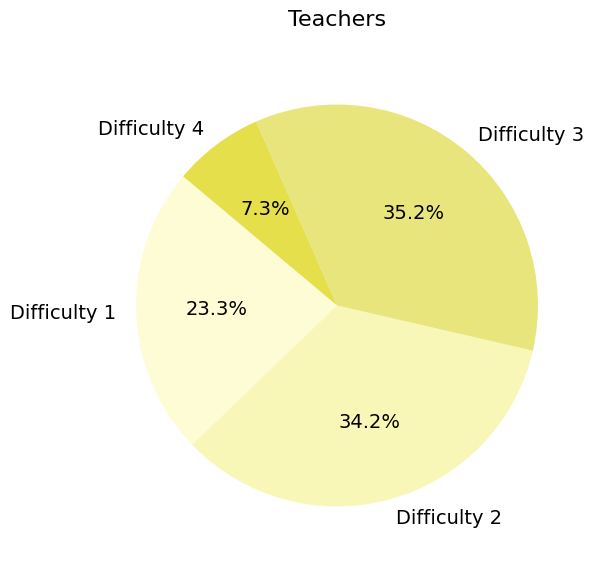

97


In [ ]:
# Teachers- What percentage of words are rated as very easy and ... (General)
tword = tword[tword['last_difficulty'].str.strip() != '']

counts = tword['last_difficulty'].value_counts().sort_index()
percentages = round(counts / counts.sum() * 100, 2)
print(percentages)

# Keep the teacher group colors
color3 = ['#FDFCD4', '#F9F7B8', '#E9E57D', '#E5DF4C']

# Apply the unified style
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pie(
    percentages.values,
    labels=[f"Difficulty {label}" for label in percentages.index],
    autopct='%1.1f%%',
    startangle=140,
    colors=color3,
    textprops={'fontsize': 14, 'family': 'sans-serif'}
)
ax.axis("equal")
ax.set_title("Teachers", fontsize=16)

plt.tight_layout()
plt.savefig("teacher_difficulty.png", bbox_inches="tight", dpi=300)
plt.show()

print(tword['Prolific ID'].nunique())



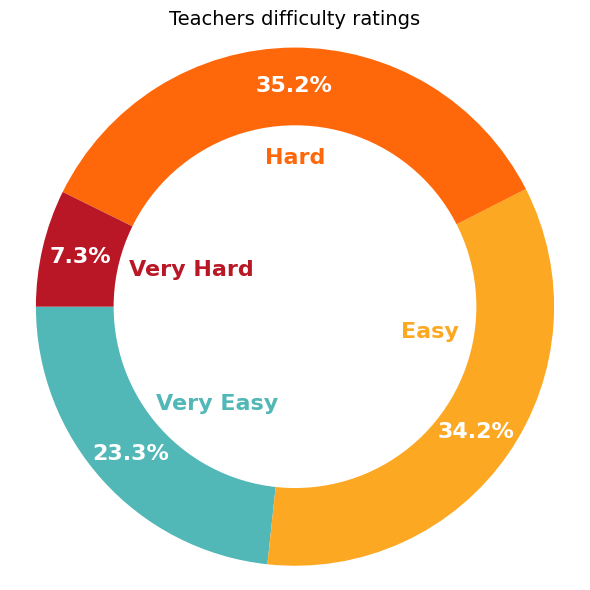

In [ ]:

plt.rcParams['font.family'] = 'DejaVu Sans'
# Your data
tword = tword[tword['last_difficulty'].str.strip() != '']

counts = tword['last_difficulty'].value_counts().sort_index()
percentages = round(counts / counts.sum() * 100, 2)
#print(percentages)

# Difficulty label mapping
difficulty_labels = {
    "1": "Very Easy",
    "2": "Easy",
    "3": "Hard",
    "4": "Very Hard"
}


colors = ['#52b7b7', '#FCA822', '#FF680A', '#B91725']
# Get labels in order
labels = [difficulty_labels.get(str(label), str(label)) for label in percentages.index]
sizes = percentages.values

# Create figure
fig, ax = plt.subplots(figsize=(6,6))

# Create donut chart
wedges, texts, autotexts = ax.pie(sizes, labels=None, colors=colors,
                                    autopct='%1.1f%%', startangle=180,
                                    textprops={'fontsize': 16, 'weight': 'bold'},
                                    pctdistance=0.85)

label_positions = [
    (-0.3, -0.4),   # Very Easy
    (0.52, -0.12),     # Easy
    (0, 0.55),     # Hard
    (-0.4, 0.12)     # Very Hard
]

for i, (label, color, pos) in enumerate(zip(labels, colors, label_positions)):
    ax.annotate(label, xy=pos, fontsize=16, color=color, weight='bold', ha='center')

# Make it a donut by drawing a white circle in the center
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

for autotext in autotexts:
    autotext.set_color('white')


ax.axis('equal')
ax.set_title("Teachers difficulty ratings", fontsize=14 )

plt.tight_layout()
plt.savefig("distribution_all.jpg", dpi=300, bbox_inches="tight")
plt.show()



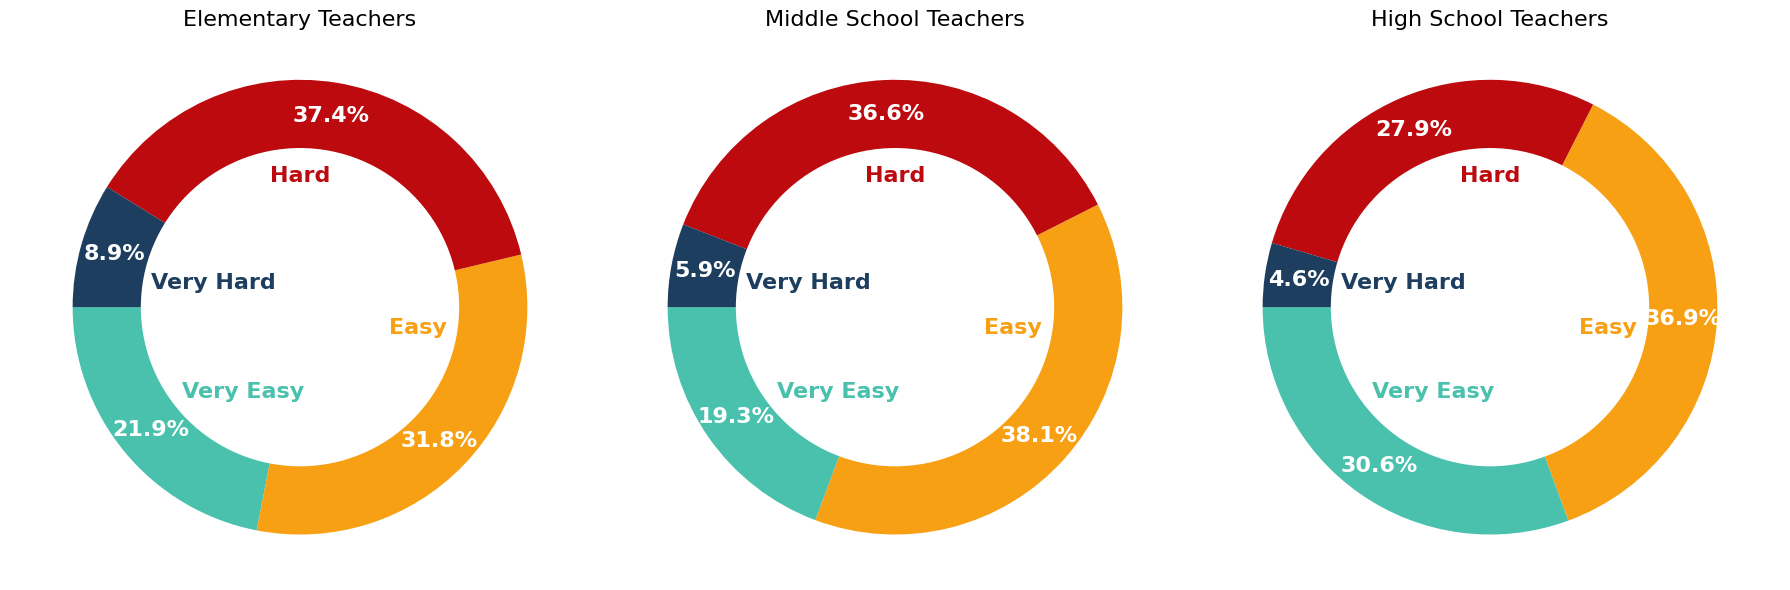

In [ ]:


color3 = ['#49C1AD', '#F7A014','#BC0A0F','#1D3E5E']

bin1 = tpre['Prolific ID'][tpre['grade category'].astype(str).str.contains(r'\b1\b')].to_list()
bin2 = tpre['Prolific ID'][tpre['grade category'].astype(str).str.contains(r'\b2\b')].to_list()
bin3 = tpre['Prolific ID'][tpre['grade category'].astype(str).str.contains(r'\b3\b')].to_list()
bin4 = tpre['Prolific ID'][tpre['grade category'].astype(str).str.contains(r'\b4\b')].to_list()

bins = [bin1, bin2, bin3]
bin_labels = ["Elementary Teachers", "Middle School Teachers", "High School Teachers"]

tword = tword[tword['last_difficulty'].str.strip() != '']
results = {}

# Difficulty label mapping
difficulty_labels = {
    "1": "Very Easy",
    "2": "Easy",
    "3": "Hard",
    "4": "Very Hard"
}

# Label positions for annotations (same for all three charts)
label_positions = [
    (-0.25, -0.4),   # Very Easy
    (0.52, -0.12),   # Easy
    (0, 0.55),       # Hard
    (-0.38, 0.08)    # Very Hard
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, bin in enumerate(bins):
    temp = tword[tword['Prolific ID'].isin(bin)]

    counts = temp['last_difficulty'].value_counts().sort_index()
    percentages = round(counts / counts.sum() * 100, 2)
    labels = [difficulty_labels.get(str(label), str(label)) for label in counts.index]
    sizes = percentages.values

    # Store percentages with mapped labels
    results[f"bin{i+1}"] = counts.rename(index=difficulty_labels) / counts.sum() * 100

    ax = axes[i]

    # Create donut chart
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,
        autopct='%1.1f%%',
        startangle=180,
        colors=color3,
        textprops={'fontsize': 16, 'weight': 'bold'},
        pctdistance=0.85,
        radius=1.0  # Explicit radius for consistency
    )

    # Add custom labels with annotations
    for j, (label, color, pos) in enumerate(zip(labels, color3, label_positions)):
        ax.annotate(label, xy=pos, fontsize=16, color=color, weight='bold', ha='center')

    # Make it a donut by drawing a white circle in the center
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Set percentage text to white
    for autotext in autotexts:
        autotext.set_color('white')

    ax.axis('equal')
    ax.set_xlim(-1.2, 1.2)  # Consistent limits
    ax.set_ylim(-1.2, 1.2)  # Consistent limits
    ax.set_title(bin_labels[i], fontsize=16)

plt.tight_layout()
plt.savefig("teacher_difficulty_by_bin.png", bbox_inches="tight", dpi=300)
plt.show()

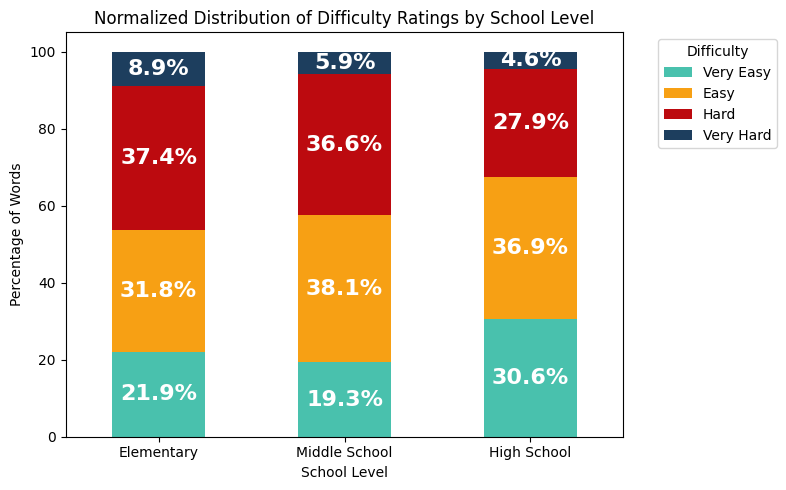

In [ ]:
# comparison

df = pd.DataFrame({
    'Elementary': results['bin1'],
    'Middle School': results['bin2'],
    'High School': results['bin3']
}).T.fillna(0)

df_percent = df.div(df.sum(axis=1), axis=0) * 100

color3 = ['#49C1AD', '#F7A014','#BC0A0F','#1D3E5E']


ax = df_percent.plot(
    kind='bar',
    stacked=True,
    color=color3,
    figsize=(8, 5)
)
# Add percentage labels on each stacked bar segment
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height <= 0:
            continue  # skip empty segments

        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2

        ax.text(
            x, y,
            f"{height:.1f}%",
            ha='center',
            va='center',
            fontsize=16,
            color='white',
            weight='bold'
        )

ax.set_ylabel("Percentage of Words")
ax.set_xlabel("School Level")
ax.set_title("Normalized Distribution of Difficulty Ratings by School Level")
ax.legend(title="Difficulty", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("teacher_difficulty_by_bin_bar.png", bbox_inches="tight", dpi=300)

plt.show()




In [ ]:
tword= tword.merge(word_dataset[['words','long_words', 'diagraphs', 'not_freq_words', 'silent_letters',
       'vowel_digraphs', 'has_homophones', 'difficult_orthography']], on = 'words', how = 'left')

In [ ]:
rating_counts.columns

Index(['words', '1', '2', '3', '4', 'total', '1%', '2%', '3%', '4%',
       'long_words', 'diagraphs', 'not_freq_words', 'silent_letters',
       'vowel_digraphs', 'has_homophones', 'difficult_orthography'],
      dtype='object')

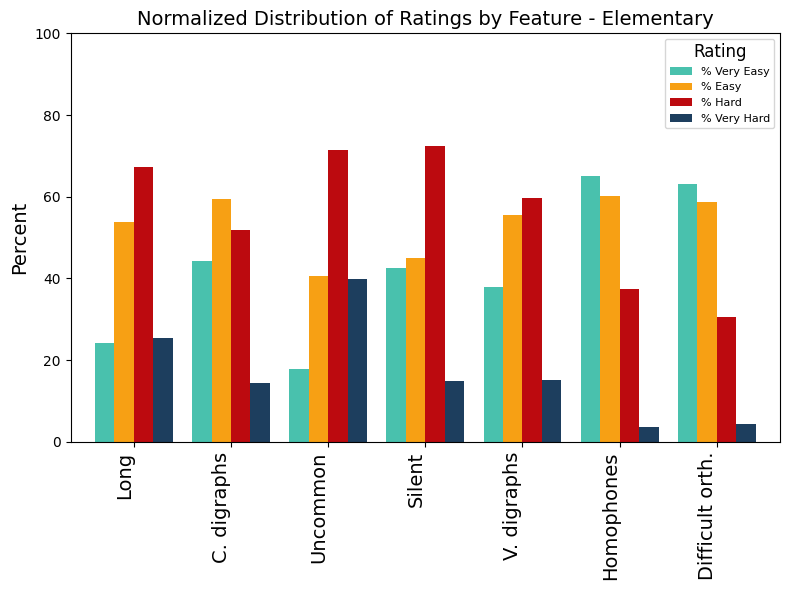

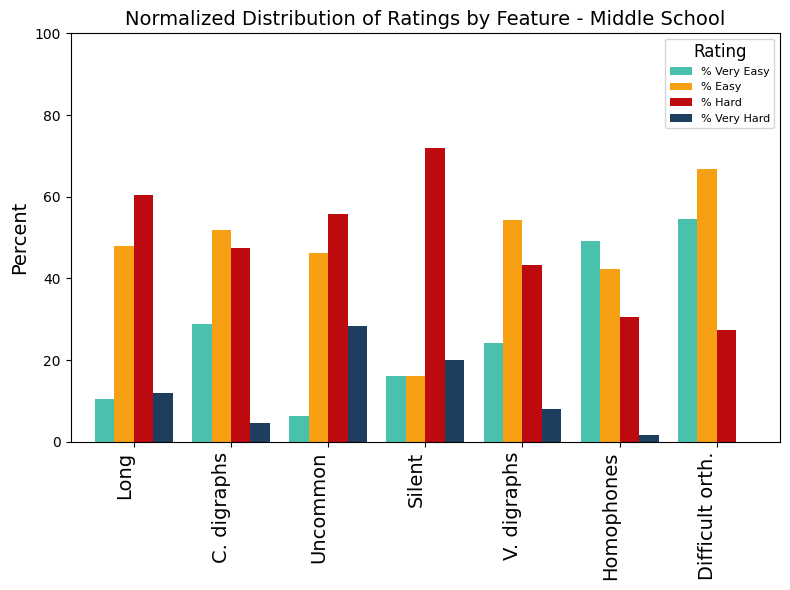

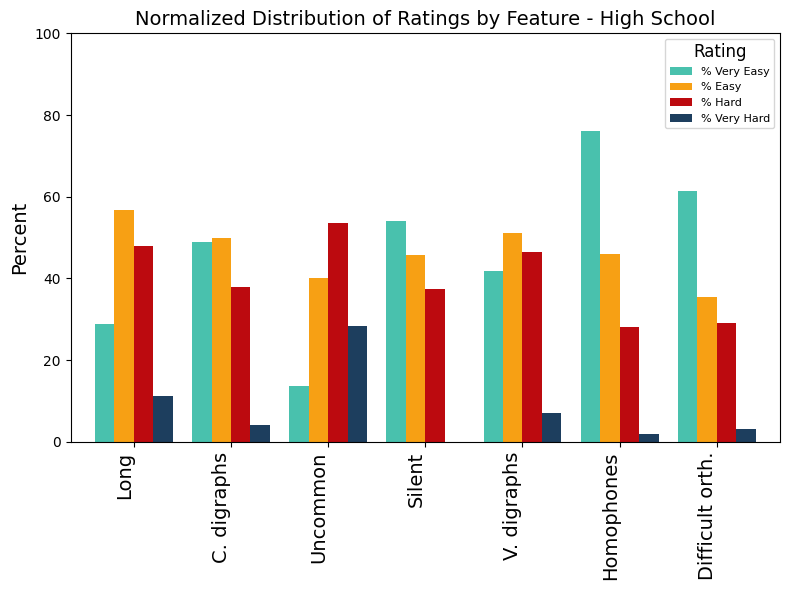

In [ ]:
short_labels = {
    'long_words': 'Long',
    'not_freq_words': 'Uncommon',
    'silent_letters': 'Silent',
    'vowel_digraphs': 'V. digraphs',
    'diagraphs': 'C. digraphs',
    'has_homophones': 'Homophones',
    'difficult_orthography': 'Difficult orth.'
}
color3 = ['#49C1AD', '#F7A014','#BC0A0F','#1D3E5E']


categories = ['long_words', 'diagraphs', 'not_freq_words',
              'silent_letters', 'vowel_digraphs', 'has_homophones',
              'difficult_orthography']

bins = [bin1, bin2, bin3]
bin_labels = ["Elementary", "Middle School", "High School"]

for i, bin in enumerate(bins):
    temp = tword[tword['Prolific ID'].isin(bin)]

    rating_counts = temp.groupby('words')['last_difficulty'].value_counts().unstack(fill_value=0)
    rating_counts['total'] = rating_counts.sum(axis=1)

    rating_counts = rating_counts.merge(
        temp[['words'] + categories].drop_duplicates(),
        left_index=True, right_on='words', how='left'
    ).set_index('words')

    for r in ['1','2','3','4']:
        rating_counts[f'{r}%'] = ((rating_counts[r] / rating_counts['total']) * 100).round(2)

    normalized_stats = {}
    for cat in categories:
        total_with_feature = rating_counts[rating_counts[cat] == 1].shape[0]
        stats_per_rating = {}
        for rating in ['1', '2', '3', '4']:
            with_feature_and_rating = rating_counts[(rating_counts[cat] == 1) & (rating_counts[rating] > 0)]
            count_with_feature_and_rating = with_feature_and_rating.shape[0]
            stats_per_rating[rating] = round(count_with_feature_and_rating / total_with_feature * 100, 2) if total_with_feature > 0 else 0
        normalized_stats[cat] = stats_per_rating

    norm_df = pd.DataFrame(normalized_stats).T
    norm_df.columns = ['% Very Easy', '% Easy', '% Hard', '% Very Hard']

    #print(norm_df)
    norm_df = norm_df.rename(index=short_labels)

    ax = norm_df.plot(
        kind='bar',
        figsize=(8, 6),
        color=color3,
        width=0.8
    )

    ax.set_title(f"Normalized Distribution of Ratings by Feature - {bin_labels[i]}", fontsize=14)
    ax.set_ylabel("Percent", fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xticklabels(norm_df.index, rotation=90, ha='right', fontsize=14)
    ax.legend(title="Rating", fontsize=8, title_fontsize=12)
    # Add numeric labels on bars
    # for container in ax.containers:
    #   for bar in container:
    #       height = bar.get_height()
    #       if height <= 0:
    #           continue

    #       x = bar.get_x() + bar.get_width() / 2

    #       if height >= 15:  # threshold you can tune
    #           # Put label inside the bar
    #           ax.text(
    #               x,
    #               height - 5,
    #               f"{height:.1f}",
    #               ha='center',
    #               va='top',
    #               fontsize=10,
    #               color='black',
    #               weight='bold'
    #           )
    #       else:
    #           # Put label above the bar
    #           ax.text(
    #               x,
    #               height + 1.5,
    #               f"{height:.1f}",
    #               ha='center',
    #               va='bottom',
    #               fontsize=10,
    #               color='gray',
    #               weight='bold'
    #           )
    plt.tight_layout()

    plt.savefig(f"teacher_normalized_levels.png", bbox_inches="tight", dpi=300)
    plt.show()

In [ ]:
import pandas as pd
import numpy as np

short_labels = {
    'long_words': 'Long',
    'not_freq_words': 'Uncommon',
    'silent_letters': 'Silent',
    'vowel_digraphs': 'V. digraphs',
    'diagraphs': 'C. digraphs',
    'has_homophones': 'Homophones',
    'difficult_orthography': 'Difficult orth.'
}

categories = ['long_words', 'diagraphs', 'not_freq_words',
              'silent_letters', 'vowel_digraphs', 'has_homophones',
              'difficult_orthography']

bins = [bin1, bin2, bin3]
bin_labels = ["Elementary", "Middle", "High"]  # keep short for column names

# will store one DataFrame per level
level_tables = {}

for i, bin_ids in enumerate(bins):
    level = bin_labels[i]
    temp = tword[tword['Prolific ID'].isin(bin_ids)].copy()

    # counts of ratings per word
    rating_counts = (
        temp.groupby('words')['last_difficulty']
            .value_counts()
            .unstack(fill_value=0)
    )

    # make sure columns 1..4 exist (as strings)
    for r in ['1', '2', '3', '4']:
        if r not in rating_counts.columns:
            rating_counts[r] = 0
    rating_counts = rating_counts[['1','2','3','4']]

    rating_counts['total'] = rating_counts.sum(axis=1)

    # attach feature indicators for each word
    rating_counts = rating_counts.merge(
        temp[['words'] + categories].drop_duplicates(),
        left_index=True, right_on='words', how='left'
    ).set_index('words')

    # ---- compute feature × rating distribution (the numbers you want) ----
    normalized_stats = {}

    for cat in categories:
        words_with_feature = rating_counts[rating_counts[cat] == 1]
        total_votes = words_with_feature[['1','2','3','4']].sum().sum()

        stats_per_rating = {}
        for r in ['1','2','3','4']:
            # total number of votes of rating r for words with this feature
            vote_count = words_with_feature[r].sum()
            stats_per_rating[r] = (
                round((vote_count / total_votes) * 100, 1)
                if total_votes > 0 else 0.0
            )

        normalized_stats[cat] = stats_per_rating


    level_df = pd.DataFrame(normalized_stats).T  # rows: features, cols: 1..4
    level_df = level_df.rename(index=short_labels)
    level_df = level_df[['1','2','3','4']]
    level_df.columns = [f"{level}_{c}" for c in level_df.columns]  # Elementary_1 etc.

    level_tables[level] = level_df

# ---- final wide table: rows=features, cols=12 ----
final_table = pd.concat(
    [level_tables["Elementary"], level_tables["Middle"], level_tables["High"]],
    axis=1
)

# Order rows nicely (optional)
row_order = ['Silent', 'Long', 'C. digraphs', 'V. digraphs', 'Homophones', 'Uncommon', 'Difficult orth.']
final_table = final_table.reindex(row_order)

print(final_table)


                 Elementary_1  Elementary_2  Elementary_3  Elementary_4  \
Silent                   21.4          19.4          52.4           6.8   
Long                     13.0          29.9          44.5          12.6   
C. digraphs              26.6          32.1          34.2           7.1   
V. digraphs              20.9          32.0          39.2           7.8   
Homophones               40.9          33.5          24.3           1.3   
Uncommon                  8.3          20.6          48.3          22.8   
Difficult orth.          42.9          35.7          19.6           1.8   

                 Middle_1  Middle_2  Middle_3  Middle_4  High_1  High_2  \
Silent               15.2       8.7      65.2      10.9    40.4    31.9   
Long                  7.3      38.4      46.0       8.4    17.4    42.9   
C. digraphs          24.2      38.2      34.4       3.2    36.2    35.5   
V. digraphs          20.2      41.5      33.3       5.0    28.3    37.1   
Homophones           43.

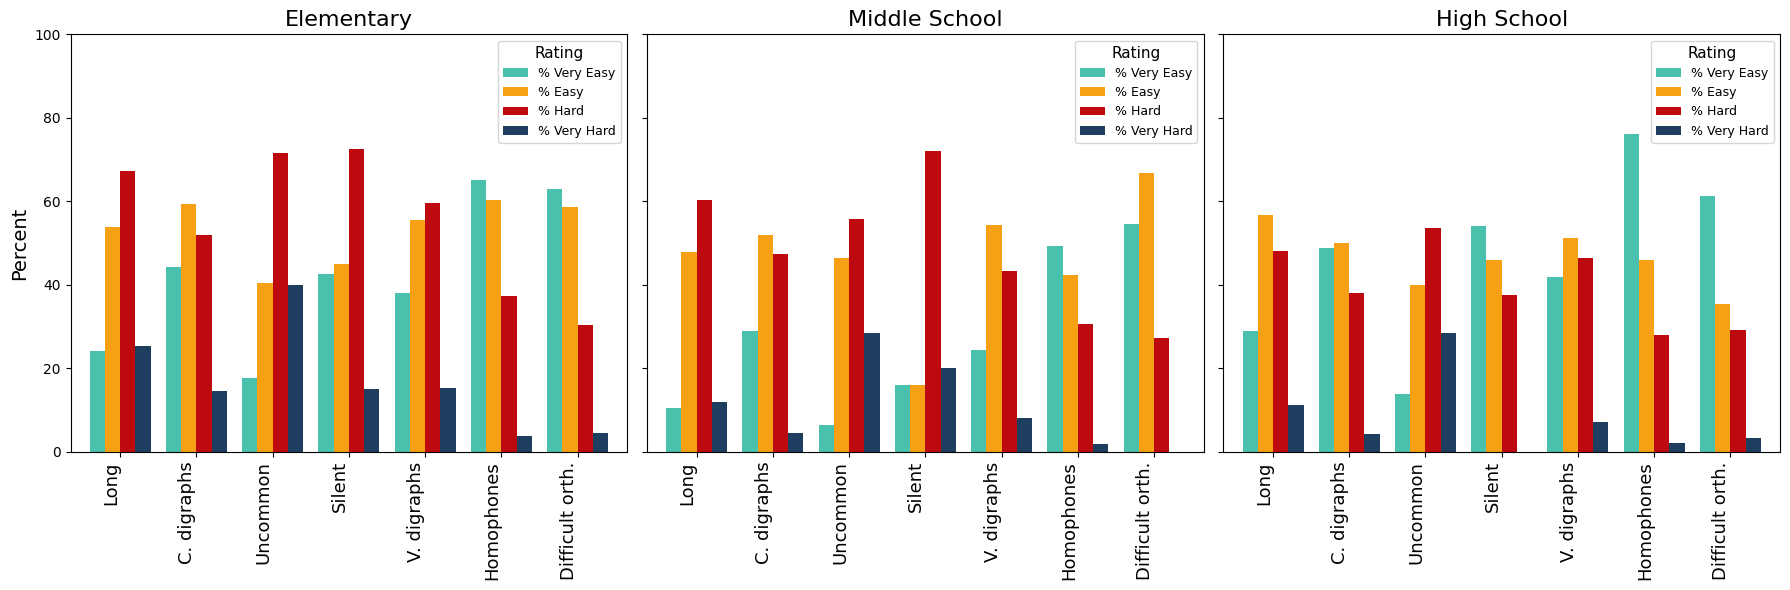

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, bin in enumerate(bins):
    temp = tword[tword['Prolific ID'].isin(bin)]

    rating_counts = temp.groupby('words')['last_difficulty'].value_counts().unstack(fill_value=0)
    rating_counts['total'] = rating_counts.sum(axis=1)

    rating_counts = rating_counts.merge(
        temp[['words'] + categories].drop_duplicates(),
        left_index=True, right_on='words', how='left'
    ).set_index('words')

    for r in ['1','2','3','4']:
        rating_counts[f'{r}%'] = ((rating_counts[r] / rating_counts['total']) * 100).round(2)

    normalized_stats = {}
    for cat in categories:
        total_with_feature = rating_counts[rating_counts[cat] == 1].shape[0]
        stats_per_rating = {}
        for rating in ['1', '2', '3', '4']:
            with_feature_and_rating = rating_counts[
                (rating_counts[cat] == 1) & (rating_counts[rating] > 0)
            ]
            count_with_feature_and_rating = with_feature_and_rating.shape[0]
            stats_per_rating[rating] = (
                round(count_with_feature_and_rating / total_with_feature * 100, 2)
                if total_with_feature > 0 else 0
            )
        normalized_stats[cat] = stats_per_rating

    norm_df = pd.DataFrame(normalized_stats).T
    norm_df.columns = ['% Very Easy', '% Easy', '% Hard', '% Very Hard']
    norm_df = norm_df.rename(index=short_labels)

    ax = axes[i]
    norm_df.plot(
        kind='bar',
        color=color3,
        width=0.8,
        ax=ax
    )

    ax.set_title(bin_labels[i], fontsize=16)
    ax.set_ylim(0, 100)
    ax.set_xticklabels(norm_df.index, rotation=90, ha='right', fontsize=13)

    if i == 0:
        ax.set_ylabel("Percent", fontsize=14)
    else:
        ax.set_ylabel("")

    ax.legend(title="Rating", fontsize=9, title_fontsize=11)

# Global layout
plt.tight_layout()
plt.savefig("teacher_normalized_levels_horizontal.png", bbox_inches="tight", dpi=300)
plt.show()


In [ ]:

# fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=False, sharey=True)

# for i, bin in enumerate(bins):
#     temp = tword[tword['Prolific ID'].isin(bin)]

#     rating_counts = temp.groupby('words')['last_difficulty'].value_counts().unstack(fill_value=0)
#     if all(isinstance(c, str) for c in rating_counts.columns):
#         rating_counts = rating_counts.reindex(columns=['1','2','3','4'], fill_value=0)
#     else:
#         rating_counts = rating_counts.reindex(columns=[1, 2, 3, 4], fill_value=0)
#         rating_counts.columns = rating_counts.columns.astype(str)

#     rating_counts['total'] = rating_counts[['1','2','3','4']].sum(axis=1)

#     rating_counts = rating_counts.merge(
#         temp[['words'] + categories].drop_duplicates(),
#         left_index=True, right_on='words', how='left'
#     ).set_index('words')
#     rating_counts[categories] = rating_counts[categories].fillna(0).astype(int)

#     rows = []
#     for cat in categories:
#         has_feat = rating_counts[cat] == 1
#         r1 = int(rating_counts.loc[has_feat, '1'].sum())
#         r2 = int(rating_counts.loc[has_feat, '2'].sum())
#         r3 = int(rating_counts.loc[has_feat, '3'].sum())
#         r4 = int(rating_counts.loc[has_feat, '4'].sum())
#         denom = r1 + r2 + r3 + r4

#         if denom == 0:
#             rows.append([0.0, 0.0, 0.0, 0.0])
#         else:
#             rows.append([
#                 round(100 * r1 / denom, 2),
#                 round(100 * r2 / denom, 2),
#                 round(100 * r3 / denom, 2),
#                 round(100 * r4 / denom, 2),
#             ])

#     plot_df = pd.DataFrame(
#         rows,
#         index=[short_labels.get(c, c) for c in categories],
#         columns=['% Very Easy', '% Easy', '% Hard', '% Very Hard']
#     )

#     ax = axes[i]
#     plot_df.plot(kind='bar', ax=ax, color=color3, width=0.8)
#     ax.set_title(bin_labels[i], fontsize=18)
#     ax.set_ylabel("Percent", fontsize=16)
#     ax.set_xlabel("")
#     ax.set_ylim(0, 100)
#     ax.set_yticks(list(range(0, 101, 10)))
#     ax.set_xticklabels(plot_df.index, rotation=90, ha='right', fontsize=12)
#     ax.tick_params(axis='y', labelsize=16)
#     ax.tick_params(axis='x', labelsize=16)
#     ax.legend().remove()

# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title="Rating", loc='upper center',
#            ncol=4, fontsize=16, title_fontsize=16)

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("ratings_by_feature_percent_vertical.png", bbox_inches="tight", dpi=300)
# plt.show()


In [ ]:
tword['hard'].value_counts()

,count
hard,
1,4223
0,1283


In [ ]:
# teacher's - XGBoost

# tword['hard'] = [0 if tword['last_difficulty'][i] == '1' else 1 for i in range(len(tword))]
# tword= tword.drop(columns=['Prolific ID', 'words', 'letters', 'reason explanation', 'date and time', 'last_difficulty' ])
X_teacher = tword.drop(columns=['hard'])
y_teacher = tword['hard']


scoring = {
    "acc": "accuracy",
    "f1": "f1",
    "roc": "roc_auc",
    "pr": "average_precision",
}

neg, pos = np.bincount(y_teacher)
scale_pos_weight = neg / pos

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = xgb.XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)






teacher_res = cross_validate(clf, X_teacher, y_teacher, cv=cv, scoring=scoring, n_jobs=-1)
print("teachers (5-fold):",
      f"Acc {np.mean(teacher_res['test_acc']):.3f}",
      f"F1 {np.mean(teacher_res['test_f1']):.3f}",
      f"ROC {np.mean(teacher_res['test_roc']):.3f}",
      f"PR {np.mean(teacher_res['test_pr']):.3f}")


def mean_std(arr):
    return f"{np.mean(arr):.3f} ± {np.std(arr):.3f}"

print("Teachers (5-fold):",
      f"Acc {mean_std(teacher_res['test_acc'])}",
      f"F1 {mean_std(teacher_res['test_f1'])}",
      f"ROC {mean_std(teacher_res['test_roc'])}",
      f"PR {mean_std(teacher_res['test_pr'])}")


teachers (5-fold): Acc 0.715 F1 0.797 ROC 0.757 PR 0.897
Teachers (5-fold): Acc 0.715 ± 0.017 F1 0.797 ± 0.015 ROC 0.757 ± 0.015 PR 0.897 ± 0.009


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate

scoring = {
    "acc": "accuracy",
    "f1": "f1",
    "roc": "roc_auc",
    "pr": "average_precision",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1) Clean last_difficulty and filter valid labels
# ld = tword["last_difficulty"].astype(str).str.strip()
# valid = ld.isin(["1", "2", "3", "4"])
df = tword.copy()

# 2) Hard = {2,3,4}, Not hard = {1}
# df["hard"] = (df["last_difficulty"].astype(str).str.strip() != "1").astype(int)

# 3) Drop non-features
# df = df.drop(columns=["Prolific ID", "words", "letters","reason explanation", "date and time", "last_difficulty"])

X_teacher = df.drop(columns=["hard"])
y_teacher = df["hard"].values

# 4) Handle imbalance properly for XGBoost
neg, pos = np.bincount(y_teacher)
scale_pos_weight = neg / pos

clf = xgb.XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

teacher_res = cross_validate(clf, X_teacher, y_teacher, cv=cv, scoring=scoring, n_jobs=-1)

def mean_std(arr):
    return f"{np.mean(arr):.3f} ± {np.std(arr):.3f}"

print("Teachers (5-fold):",
      f"PR-AUC {mean_std(teacher_res['test_pr'])}",
      f"ROC-AUC {mean_std(teacher_res['test_roc'])}",
      f"F1 {mean_std(teacher_res['test_f1'])}",
      f"Acc {mean_std(teacher_res['test_acc'])}")


Teachers (5-fold): PR-AUC 0.897 ± 0.009 ROC-AUC 0.757 ± 0.015 F1 0.797 ± 0.015 Acc 0.715 ± 0.017


In [ ]:
pos_rate = y_teacher.mean()
print("Positive rate:", round(pos_rate, 3))
print("PR-AUC baseline:", round(pos_rate, 3))


Positive rate: 0.767
PR-AUC baseline: 0.767


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


def plot_cv_curves(X, y, model, n_splits=5, title="cv_curves"):
  y = np.asarray(y)
  cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  mean_fpr = np.linspace(0, 1, 200)
  mean_recall = np.linspace(0, 1, 200)

  tprs = []
  roc_aucs = []
  precs_interp = []
  pr_aucs = []

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]

    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)

    tpr_i = np.interp(mean_fpr, fpr, tpr)
    tpr_i[0] = 0.0
    tprs.append(tpr_i)

    axes[0].plot(fpr, tpr, lw=1, alpha=0.5)
    axes[0].text(0.60, 0.10 + 0.05*fold, "Fold " + str(fold) + " AUC=" + format(roc_auc, ".2f"), transform=axes[0].transAxes, fontsize=8)

    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    pr_aucs.append(ap)

    prec_i = np.interp(mean_recall, recall[::-1], precision[::-1])
    precs_interp.append(prec_i)

    axes[1].plot(recall, precision, lw=1, alpha=0.5)
    axes[1].text(0.60, 0.10 + 0.05*fold, "Fold " + str(fold) + " AP=" + format(ap, ".2f"), transform=axes[1].transAxes, fontsize=8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_roc_auc = np.mean(roc_aucs)

  axes[0].plot(mean_fpr, mean_tpr, lw=2)
  axes[0].plot([0, 1], [0, 1], "--", lw=1)
  axes[0].set_xlabel("False Positive Rate")
  axes[0].set_ylabel("True Positive Rate")
  axes[0].set_title("ROC")
  axes[0].text(0.60, 0.05, "Mean AUC=" + format(mean_roc_auc, ".2f"), transform=axes[0].transAxes, fontsize=9, fontweight="bold")

  mean_prec = np.mean(precs_interp, axis=0)
  mean_ap = np.mean(pr_aucs)

  axes[1].plot(mean_recall, mean_prec, lw=2)
  axes[1].set_xlabel("Recall")
  axes[1].set_ylabel("Precision")
  axes[1].set_title("Precision-Recall")
  axes[1].text(0.60, 0.05, "Mean AP=" + format(mean_ap, ".2f"), transform=axes[1].transAxes, fontsize=9, fontweight="bold")

  fig.suptitle(title)
  plt.tight_layout()
  plt.savefig(title.replace(" ", "_") + ".png", bbox_inches="tight", dpi=300)
  plt.show()


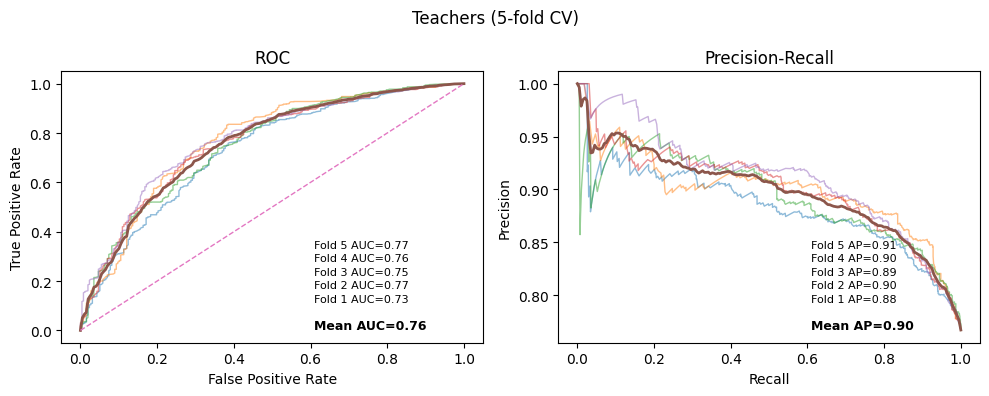

In [ ]:
plot_cv_curves(X_teacher, y_teacher, clf, n_splits=5, title="Teachers (5-fold CV)")


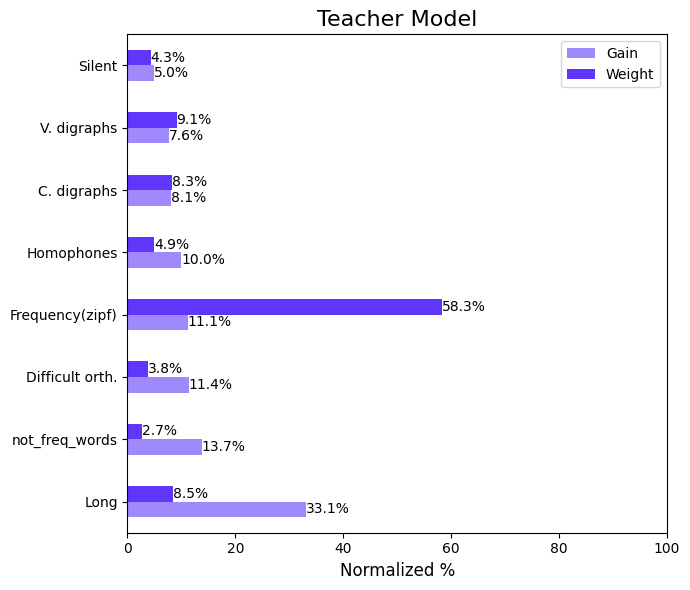

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # Fit teacher model (needed for booster importance)
# model_teacher = clf.fit(X_teacher, y_teacher)

# # Extract importance
# importance_teacher_gain   = model_teacher.get_booster().get_score(importance_type='gain')
# importance_teacher_weight = model_teacher.get_booster().get_score(importance_type='weight')
# importance_teacher_cover  = model_teacher.get_booster().get_score(importance_type='cover')

# def normalize_importance(gain_dict, weight_dict):
#     gain_df = pd.DataFrame(list(gain_dict.items()), columns=['Feature', 'Gain'])
#     weight_df = pd.DataFrame(list(weight_dict.items()), columns=['Feature', 'Weight'])
#     df = pd.merge(gain_df, weight_df, on="Feature", how="outer").fillna(0)

#     if df['Gain'].sum() > 0:
#         df['Gain'] = df['Gain'] / df['Gain'].sum() * 100
#     if df['Weight'].sum() > 0:
#         df['Weight'] = df['Weight'] / df['Weight'].sum() * 100

#     return df.set_index("Feature")

# df_teacher = normalize_importance(importance_teacher_gain, importance_teacher_weight)

# # Map f0,f1,... -> real feature names
# feature_names = list(X_teacher.columns)
# df_teacher.index = df_teacher.index.map(
#     lambda k: feature_names[int(k[1:])] if isinstance(k, str) and k.startswith("f") else k
# )

# # Use the same short labels
# short_labels = {
#     'long_words': 'Long',
#     'zipf': 'Frequency(zipf)',
#     'silent_letters': 'Silent',
#     'vowel_digraphs': 'V. digraphs',
#     'diagraphs': 'C. digraphs',
#     'has_homophones': 'Homophones',
#     'difficult_orthography': 'Difficult orth.'
# }

# df_teacher_plt = df_teacher.rename(index=short_labels)

# # Plot
# colors = ["#A089FD", "#6136FC"]
# ax = df_teacher_plt[['Gain', 'Weight']].sort_values('Gain', ascending=False).plot(
#     kind="barh",
#     figsize=(7, 6),
#     color=colors
# )

# ax.set_title("Teacher Model", fontdict={'fontsize': 16, 'family': 'sans-serif'})
# ax.set_xlabel("Normalized %", fontsize=12, fontfamily='sans-serif')
# ax.legend(["Gain", "Weight"], fontsize=10)

# ax.set_xlim(0, 100)
# add_bar_labels(ax)  # your existing function
# ax.set_ylabel("")
# plt.tight_layout()
# plt.savefig("teacher_informationGain.png", bbox_inches="tight", dpi=300)
# plt.show()


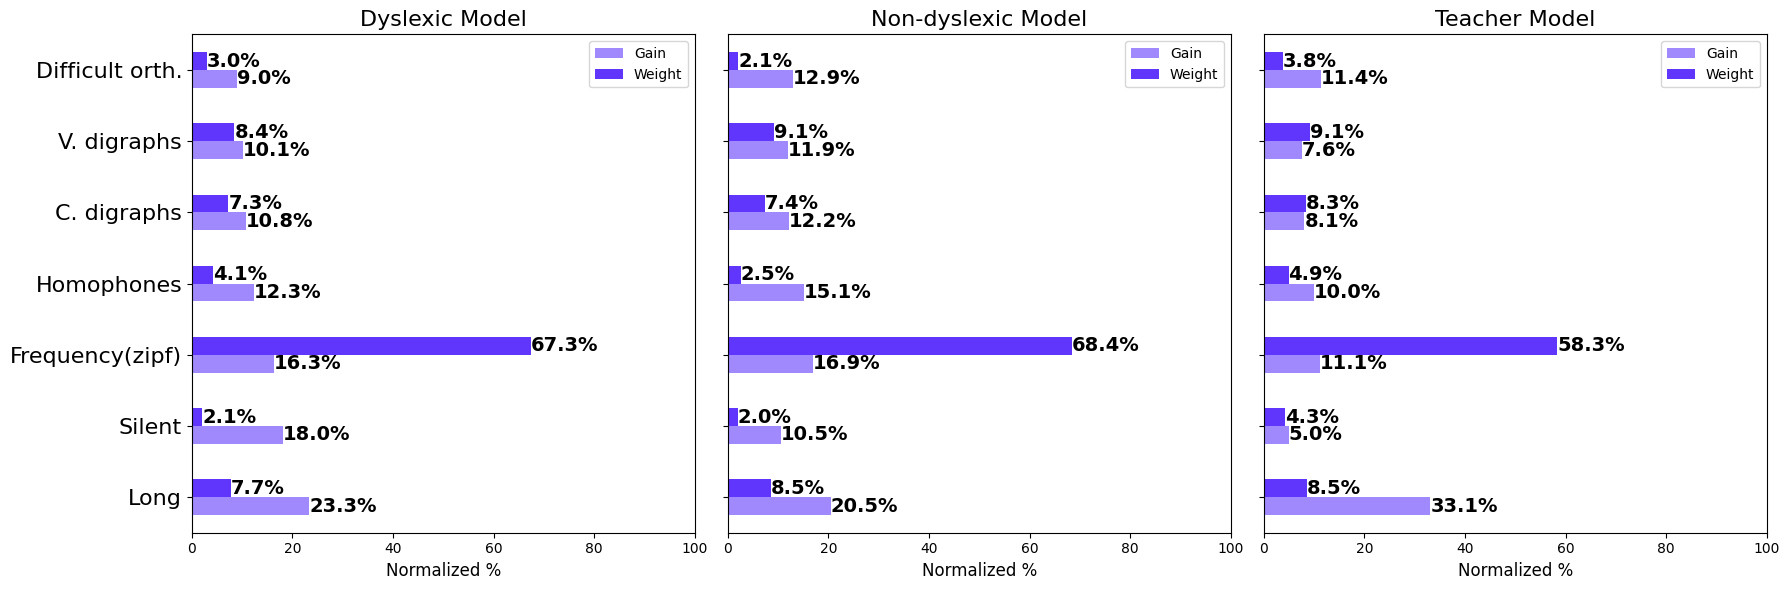

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def add_bar_labels(ax, fmt="{:.1f}%"):
    for container in ax.containers:
        for bar in container:
            width = bar.get_width()
            if width <= 0:
                continue

            ax.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                fmt.format(width),
                va="center",
                ha="left",
                fontsize=14,
                fontfamily="DejaVu Sans",   # change font here
                fontweight="bold",          # normal / bold
                color="black"
            )
# --- keep your short labels and colors exactly ---
short_labels = {
    'long_words': 'Long',
    'zipf': 'Frequency(zipf)',
    'silent_letters': 'Silent',
    'vowel_digraphs': 'V. digraphs',
    'diagraphs': 'C. digraphs',
    'has_homophones': 'Homophones',
    'difficult_orthography': 'Difficult orth.'
}
colors = ["#A089FD", "#6136FC"]

def normalize_importance(gain_dict, weight_dict):
    gain_df = pd.DataFrame(list(gain_dict.items()), columns=['Feature', 'Gain'])
    weight_df = pd.DataFrame(list(weight_dict.items()), columns=['Feature', 'Weight'])
    df = pd.merge(gain_df, weight_df, on="Feature", how="outer").fillna(0)

    if df['Gain'].sum() > 0:
        df['Gain'] = df['Gain'] / df['Gain'].sum() * 100
    if df['Weight'].sum() > 0:
        df['Weight'] = df['Weight'] / df['Weight'].sum() * 100

    return df.set_index("Feature")

def map_f_to_names(df_imp, feature_names):
    # map f0,f1,... -> actual column names when present
    df_imp = df_imp.copy()
    df_imp.index = df_imp.index.map(
        lambda k: feature_names[int(k[1:])] if isinstance(k, str) and k.startswith("f") else k
    )
    return df_imp

# ----------------------------
# 1) TEACHER importance
# ----------------------------
model_teacher = clf.fit(X_teacher, y_teacher)
imp_teacher_gain = model_teacher.get_booster().get_score(importance_type='gain')
imp_teacher_weight = model_teacher.get_booster().get_score(importance_type='weight')

df_teacher = normalize_importance(imp_teacher_gain, imp_teacher_weight)
df_teacher = map_f_to_names(df_teacher, list(X_teacher.columns))

# ----------------------------
# 2) DYS / NONDYS importance
# ----------------------------
imp_dys_gain = model_dys.get_booster().get_score(importance_type='gain')
imp_dys_weight = model_dys.get_booster().get_score(importance_type='weight')

imp_nondys_gain = model_nondys.get_booster().get_score(importance_type='gain')
imp_nondys_weight = model_nondys.get_booster().get_score(importance_type='weight')

df_dys = normalize_importance(imp_dys_gain, imp_dys_weight)
df_nondys = normalize_importance(imp_nondys_gain, imp_nondys_weight)

# Align feature order using dys as anchor (your original logic)
dys_order = df_dys.sort_values('Gain', ascending=False).index.tolist()
common_order = dys_order + [f for f in df_nondys.index if f not in dys_order]

df_dys_aligned = df_dys.reindex(common_order).fillna(0)
df_nondys_aligned = df_nondys.reindex(common_order).fillna(0)

# Also align teacher to same order (add missing as 0)
df_teacher_aligned = df_teacher.reindex(common_order).fillna(0)

# Rename for display
df_teacher_plt = df_teacher_aligned.rename(index=short_labels)
df_dys_plt = df_dys_aligned.rename(index=short_labels)
df_nondys_plt = df_nondys_aligned.rename(index=short_labels)

# ----------------------------
# 3) ONE FIGURE, 3 PANELS (Teacher on the RIGHT)
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Dyslexic (LEFT)
df_dys_plt[['Gain', 'Weight']].plot(kind="barh", color=colors, ax=axes[0])
axes[0].set_title("Dyslexic Model",
                  fontdict={'fontsize': 16, 'family': 'sans-serif'})
axes[0].set_xlabel("Normalized %", fontsize=12, fontfamily='sans-serif')
axes[0].legend(["Gain", "Weight"], fontsize=10)

# Non-dyslexic (MIDDLE)
df_nondys_plt[['Gain', 'Weight']].plot(kind="barh", color=colors, ax=axes[1])
axes[1].set_title("Non-dyslexic Model",
                  fontdict={'fontsize': 16, 'family': 'sans-serif'})
axes[1].set_xlabel("Normalized %", fontsize=12, fontfamily='sans-serif')
axes[1].legend(["Gain", "Weight"], fontsize=10)

# Teacher (RIGHT)
df_teacher_plt[['Gain', 'Weight']].plot(kind="barh", color=colors, ax=axes[2])
axes[2].set_title("Teacher Model",
                  fontdict={'fontsize': 16, 'family': 'sans-serif'})
axes[2].set_xlabel("Normalized %", fontsize=12, fontfamily='sans-serif')
axes[2].legend(["Gain", "Weight"], fontsize=10)

# Shared formatting
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_ylabel("")
    add_bar_labels(ax)

# Only left panel shows y-tick labels cleanly
axes[0].tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig("informationGain_3panel.png", bbox_inches="tight", dpi=300)
plt.show()


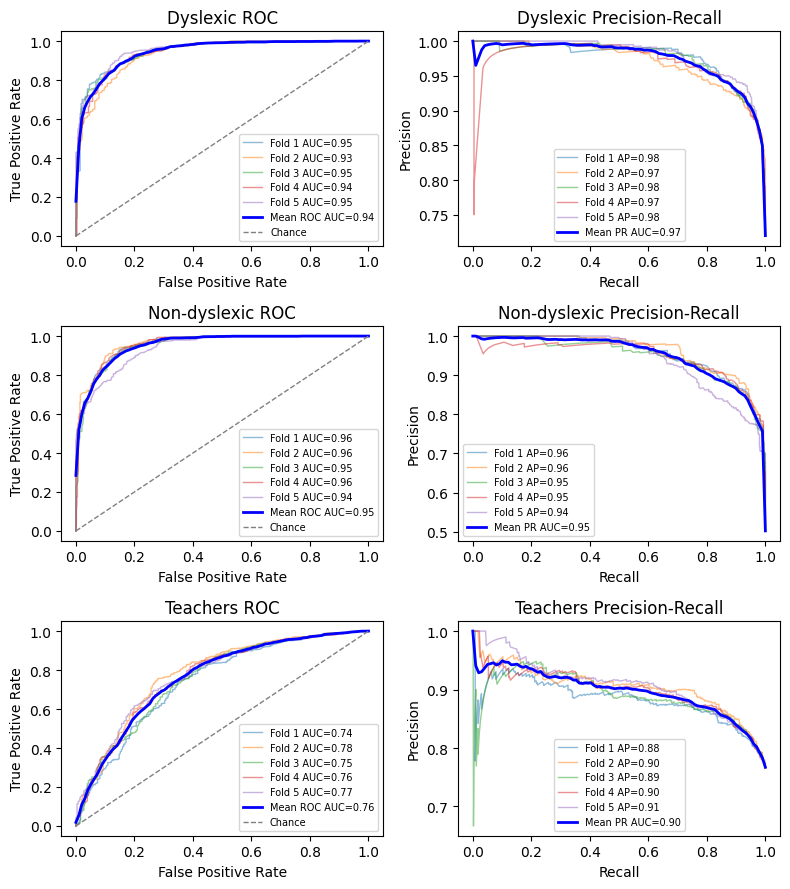

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_cv_curves_on_axes(X, y, model, axes, n_splits=5, title=""):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    y_arr = np.asarray(y)

    tprs, aucs = [], []
    precisions, pr_aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    mean_rec = np.linspace(0, 1, 100)

    ax_roc, ax_pr = axes

    for fold, (train, test) in enumerate(cv.split(X, y_arr), start=1):
        model.fit(X.iloc[train], y_arr[train])
        proba = model.predict_proba(X.iloc[test])[:, 1]

        # ROC
        fpr, tpr, _ = roc_curve(y_arr[test], proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        ax_roc.plot(fpr, tpr, lw=1, alpha=0.5, label=f"Fold {fold} AUC={roc_auc:.2f}")

        # PR
        prec, rec, _ = precision_recall_curve(y_arr[test], proba)
        ap = average_precision_score(y_arr[test], proba)
        pr_aucs.append(ap)
        precisions.append(np.interp(mean_rec, rec[::-1], prec[::-1]))
        ax_pr.plot(rec, prec, lw=1, alpha=0.5, label=f"Fold {fold} AP={ap:.2f}")

    # Mean ROC (blue)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    ax_roc.plot(mean_fpr, mean_tpr, color="blue", lw=2, label=f"Mean ROC AUC={mean_auc:.2f}")
    ax_roc.plot([0, 1], [0, 1], "--", color="gray", lw=1, label="Chance")
    ax_roc.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=f"{title} ROC")
    ax_roc.legend(fontsize=7)

    # Mean PR (blue)
    mean_prec = np.mean(precisions, axis=0)
    mean_ap = np.mean(pr_aucs)
    ax_pr.plot(mean_rec, mean_prec, color="blue", lw=2, label=f"Mean PR AUC={mean_ap:.2f}")
    ax_pr.set(xlabel="Recall", ylabel="Precision", title=f"{title} Precision-Recall")
    ax_pr.legend(fontsize=7)

# One picture: Dys, Non-dys, Teachers (3 rows x 2 cols)
fig, axes = plt.subplots(3, 2, figsize=(8, 9))

clf_dys = xgb.XGBClassifier(tree_method="hist", eval_metric="logloss", random_state=42)
plot_cv_curves_on_axes(X_dys, y_dys, clf_dys, axes=(axes[0,0], axes[0,1]), title="Dyslexic")

clf_nondys = xgb.XGBClassifier(tree_method="hist", eval_metric="logloss", random_state=42)
plot_cv_curves_on_axes(X_nondys, y_nondys, clf_nondys, axes=(axes[1,0], axes[1,1]), title="Non-dyslexic")

clf_teacher = xgb.XGBClassifier(tree_method="hist", eval_metric="logloss", random_state=42)
plot_cv_curves_on_axes(X_teacher, y_teacher, clf_teacher, axes=(axes[2,0], axes[2,1]), title="Teachers")

plt.tight_layout()
plt.savefig("cv_curves_dys_nondys_teachers.png", dpi=300, bbox_inches="tight")
plt.show()
